<h1 style='text-align: center;'>Hotel Booking Demand: Part 2</h1>
<h5 style='text-align: center;'>Created by: Umam Ihsanil Ummah & Garudapaksi Yusuf</h5>

# **Contents**

* Data Preprocessing
    * Correlation
    * Outlier
    * Cardinality
    * Imbalanced Data
* Modeling
    * Experiment Environment
    * Model Experimentation
    * Model Evaluation
    * Model Explanation
    * Model Implementation
* Conclusion

---

# **Data Preprocessing**

In [1]:
# Importing libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from phik import phik_matrix

# Loading cleaned dataset
data = pd.read_csv(filepath_or_buffer='hotel_bookings_cleaned.csv')

# Copying dataset
df = data.copy()\
         .drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights',
                        'adults', 'children', 'babies']) # Dropping columns

Notes:
* Copying dataset to avoid [chained indexing](https://pandas.pydata.org/docs/user_guide/indexing.html#indexing-view-versus-copy).
* Columns/variables which are recategorized into another column (`stays_in_weekend_nights`, and `stays_in_week_nights` into `total_stays_in_nights`; `adults`, `children`, and `babies` into `total_guests`) **will be discarded in this section**.  

## Correlation

### Numerical Variables

In [2]:
# Listing numerical columns
numerical_target_vars = df.select_dtypes(include='number')

# Setting runtime configuration
plt.rcParams['image.cmap'] = 'YlGnBu'

# Computing pairwise correlation of numerical variables
numerical_target_vars.corr(method='spearman', # Using Spearman's method for non-parametric variables
                           numeric_only=True)\
                     .style.background_gradient(cmap=None).format(formatter='{:.3f}') # Adding colors & rounding numbers displayed

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,total_stays_in_nights,total_guests,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000,0.225,0.087,-0.000,0.005,0.103,0.101,-0.090,0.126,-0.101,-0.125,0.015,0.141,-0.186,-0.129
lead_time,0.225,1.000,0.136,0.097,0.012,0.455,0.213,-0.220,0.000,-0.191,0.056,0.098,0.101,-0.110,0.061
arrival_date_year,0.087,0.136,1.000,-0.516,-0.011,0.022,0.066,0.023,-0.109,0.033,-0.005,-0.029,0.189,-0.041,0.066
arrival_date_week_number,-0.000,0.097,-0.516,1.000,0.088,0.046,0.032,-0.039,0.047,-0.047,0.018,-0.000,0.114,0.010,0.044
arrival_date_day_of_month,0.005,0.012,-0.011,0.088,1.000,-0.016,0.011,-0.004,-0.004,-0.001,0.005,0.012,0.019,0.008,-0.003
total_stays_in_nights,0.103,0.455,0.022,0.046,-0.016,1.000,0.195,-0.179,-0.039,-0.163,0.047,-0.010,0.092,-0.063,0.064
total_guests,0.101,0.213,0.066,0.032,0.011,0.195,1.000,-0.206,-0.088,-0.223,-0.021,-0.044,0.421,0.032,0.172
is_repeated_guest,-0.090,-0.220,0.023,-0.039,-0.004,-0.179,-0.206,1.000,0.250,0.825,0.013,-0.014,-0.177,0.071,-0.011
previous_cancellations,0.126,0.000,-0.109,0.047,-0.004,-0.039,-0.088,0.250,1.000,0.247,-0.017,0.021,-0.081,-0.008,-0.009
previous_bookings_not_canceled,-0.101,-0.191,0.033,-0.047,-0.001,-0.163,-0.223,0.825,0.247,1.000,0.019,-0.005,-0.167,0.087,-0.002


Notes:
* Using runtime configuration to change the visual appearance of plots in this section.
* If there are no repeated/duplicated data values, a perfect Spearman's correlation (ρ) of +1 or −1 occurs when each of the variables is a perfect monotone (linear) function of the other. If Y variable tends to increase when X variable increases, the Spearman correlation coefficient is positive —and vice versa for the negative.
* Pairing of variables with high positive correlation value (ρ-value of 0.66 - 1) are:
    * `is_repeated_guest` & `previous_bookings_not_canceled` (ρ = 0.825)
* Highly correlated variables provide redundant information and reducing prediction model's ability to generalize (causing overfitting). Therefore, **variable which causes this correlation will not be used: `previous_bookings_not_canceled`**.
* Also to reduce the number of variables while minimizing loss of data information used in modeling, several columns which provide informations regarding the arrival date of customers (namely `arrival_date_year`, `arrival_date_month`, and `arrival_date_day_of_month`) will be recategorized (as shown below).

In [3]:
# Converting columns with 'datetime' information in dataset
df['arrival_date'] = pd.to_datetime(arg={'year': df.arrival_date_year,
                                         'month': pd.to_datetime(arg=df.arrival_date_month, format='%B').dt.month,
                                         'day': df.arrival_date_day_of_month})

# Converting 'datetime' column to 'dayofweek'
df['day_of_week'] = df['arrival_date'].dt.dayofweek

# Inserting new value in 'arrival_date_year' index location
df.insert(loc=df.columns.get_loc(key='arrival_date_year'), 
          column='arrival_day_type', 
          value=df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')) # Defining function to denotes 'Weekday' and 'Weekend'

# Dropping redundant columns
df.drop(columns=['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'arrival_date', 'day_of_week'], inplace=True)

# Verifying process
with pd.option_context('display.max_columns', None):
    display(df.sample(n=5))

,hotel,is_canceled,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
31905,Resort Hotel,0,0,Weekend,July,1,4,BB,PRT,Online TA,TA/TO,0,0,0,C,C,0,No Deposit,0,Transient,230.00,0,0,Check-Out,2017-07-16
35874,City Hotel,1,104,Weekday,October,2,1,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,0,Transient-Party,91.50,0,0,1,2015-08-22
23847,Resort Hotel,0,123,Weekday,October,5,2,BB,SWE,Groups,Corporate,0,0,0,G,G,2,No Deposit,0,Transient-Party,115.00,0,0,Check-Out,2016-10-26
30033,Resort Hotel,0,26,Weekday,May,3,2,BB,GBR,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Transient,80.75,0,0,Check-Out,2017-05-20
52993,City Hotel,0,3,Weekday,September,1,2,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Contract,126.00,0,1,Check-Out,2015-09-15


Notes:
* Inserting `arrival_day_type` in place of `arrival_date_year` is done for the sake of easier readability and interpretaion of informations in dataset.
* `dayofweek` is property from Pandas which provides information regarding the day of the week from a `datetime (dt)` values, with `Monday = 0` and `Sunday = 6`
    * By using this, user can infer `Weekday` days by selecting `dt` values from 0 to 4 (Monday to Friday), and `Weekend` days from 5 to 6 (Saturday and Sunday).
* Considering Exploratory Data Analysis section provides insight regarding the effect of monthly cancellation rate, this variable will be remained.
    * But **information provided by `arrival_date_week_number` will be redundant with this new column and is therefore dropped**.


### Categorical Variables

In [4]:
# Selecting categorical variables as subset
categorical_target_vars = df.select_dtypes(include='object')\
                            .combine_first(other=df[['is_canceled']]) # Combining subset with target variable

# Computing pairwise correlation of categorical & target variables
phik_matrix(df=categorical_target_vars, 
            # Applying target as interval column/variable
            interval_cols='is_canceled').style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,arrival_day_type,assigned_room_type,country,customer_type,deposit_type,distribution_channel,hotel,is_canceled,market_segment,meal,reservation_status,reservation_status_date,reserved_room_type
arrival_date_month,1.000,0.086,0.095,0.262,0.213,0.114,0.125,0.076,0.108,0.168,0.147,0.151,0.977,0.110
arrival_day_type,0.086,1.000,0.037,0.054,0.024,0.008,0.072,0.048,0.019,0.086,0.064,0.007,0.232,0.054
assigned_room_type,0.095,0.037,1.000,0.139,0.175,0.135,0.146,0.477,0.120,0.171,0.346,0.148,0.219,0.940
country,0.262,0.054,0.139,1.000,0.230,0.226,0.316,0.445,0.235,0.401,0.232,0.322,0.505,0.163
customer_type,0.213,0.024,0.175,0.230,1.000,0.053,0.111,0.094,0.193,0.453,0.194,0.097,0.493,0.152
deposit_type,0.114,0.008,0.135,0.226,0.053,1.000,0.049,0.034,0.100,0.304,0.034,0.342,0.581,0.081
distribution_channel,0.125,0.072,0.146,0.316,0.111,0.049,1.000,0.111,0.123,0.772,0.115,0.147,0.333,0.224
hotel,0.076,0.048,0.477,0.445,0.094,0.034,0.111,1.000,0.108,0.164,0.467,0.043,0.260,0.408
is_canceled,0.108,0.019,0.120,0.235,0.193,0.100,0.123,0.108,1.000,0.206,0.082,1.000,0.367,0.072
market_segment,0.168,0.086,0.171,0.401,0.453,0.304,0.772,0.164,0.206,1.000,0.231,0.234,0.477,0.210


Notes:
* [Phi_K](https://phik.readthedocs.io/en/latest/) (ϕk) library is used to compute correlation between categorical and interval variables.
    * Based on Pearson's chi-squared contingency test —a hypothesis test for independence between two or more variables.
    * `is_canceled` is added into this analysis because we would want to find the association between categorical variables and the target of this prediction model, and also applied as interval variable because the difference between values in this column (`1` or `0`) is meaningful.
    * Phi_K correlation matrix drops missing value from the data to calculate the correlation coefficient by default (parameter `dropna` already set to `True`).
    * It captures any non-linear relationship between variables, and has a built-in noise reduction against statistical fluctuations or outliers (parameter `noise_correction` also set to `True` by default).
    * Correlation coefficient value is between 0 and 1, hence no indication of relationship direction between variables.
* Variable pairings with high correlation value (ϕk value of 0.66 - 1) are:
    * `assigned_room_type` and `reserved_room_type` (ϕk = `0.940`)
        * This project is focusing on the booking aspect of Hotel clients —information provided by them in the booking process.
        * `reserved_room_type` is data inputted by Hotel by the time clients are finished with their booking process; therefore, **this variable will not be used in booking cancellation inference**.
    * `is_canceled` and `reservation_status` (ϕk = `1.000`; perfectly correlated)
        * `reservation_status` —and its complementary information in `reservation_status_date` also uses above explanation, and **will be dropped**.
    * `market_segment` and `distribution_channel` (ϕk = `0.772`)
        * Either of these variables are potential in predicting cancellation, and both contains similar information. **One of them will be used in this section and the other ignored in building model algorithm**.

In [5]:
# Dropping correlated variables from dataset
df.drop(columns=['previous_bookings_not_canceled', 'assigned_room_type', 'reservation_status', 'reservation_status_date'], inplace=True)

# Detecting duplicated data (after subsetting variables)
df[df.duplicated()]

,hotel,is_canceled,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,...,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
403,Resort Hotel,0,57,Weekday,July,2,2,FB,PRT,Groups,...,0,0,A,0,No Deposit,0,Transient-Party,107.00,0,0
406,Resort Hotel,0,57,Weekday,July,2,2,FB,PRT,Groups,...,0,0,A,0,No Deposit,0,Transient,107.00,0,0
411,Resort Hotel,0,57,Weekday,July,2,1,FB,PRT,Groups,...,0,0,A,1,No Deposit,0,Transient-Party,94.00,0,0
1296,Resort Hotel,1,57,Weekday,August,4,3,HB,PRT,Offline TA/TO,...,0,0,A,0,No Deposit,0,Transient,133.00,0,1
1912,Resort Hotel,1,81,Weekend,September,7,2,BB,PRT,Online TA,...,0,0,A,0,No Deposit,0,Transient,66.29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86337,City Hotel,0,176,Weekday,August,2,2,HB,DEU,Direct,...,0,0,A,1,No Deposit,0,Transient,135.00,0,1
86483,City Hotel,0,142,Weekday,August,1,2,BB,USA,Direct,...,0,0,D,1,No Deposit,0,Transient,150.00,0,2
86581,City Hotel,0,457,Weekday,August,2,2,HB,DEU,Offline TA/TO,...,0,0,A,1,No Deposit,0,Transient-Party,122.40,0,1
86836,City Hotel,0,213,Weekday,August,4,1,HB,PRT,Groups,...,0,0,A,1,No Deposit,0,Transient-Party,104.00,0,0


Notes:
* **These variables (excluding `is_canceled` as the target) will be the features used in prediction modeling**.
* Subsetting variables may re-raise data duplication issue.
    * Data points which are different from each other in complete dataset may become similar if certain variables are dropped.
* Similar with explanation from previous section, **these data will be dropped to avoid overfitting**.

In [6]:
# Handling duplicated data
df.drop_duplicates(inplace=True)

# Verifying process
pd.DataFrame(data={'Dataset (Original)': data.shape,
                   'Dataset (Modeling)': df.shape,
                   'Dropped Data': (data.shape[0] - df.shape[0], data.shape[1] - df.shape[1])},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Dataset (Original),86940,32
Dataset (Modeling),85154,21
Dropped Data,1786,11


## Outlier

In [7]:
# Defining function for detecting outlier
def detect_outlier(variable):
    Q1, Q3 = df[variable].quantile(q=0.25), df[variable].quantile(q=0.75)
    IQR = Q3 - Q1
    lower_boundary, upper_boundary = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df.loc[(df[variable] <  (lower_boundary)) | (df[variable] > (upper_boundary))]
    return outliers

Notes:

Outlier detection uses adjusted box-plot method:
* Used for data with non-normal (skewed) distribution.
* Q1 and Q3 are defined as 25th and 75th percentile of the data, respectively.
* Interquartile range (IQR) as the distance between Q1 and Q3.
* Boundaries for this method are defined as 1.5 of IQR for both side, and
* Data points outside these boundaries are flagged as outliers.

In [8]:
# Selecting numeric variables
numeric_vars = df.select_dtypes(include='number').drop(columns='is_canceled')

# Showing summary of outlier in numerical variables
pd.DataFrame(data={'numeric_variables': numeric_vars.columns,
                   'n': [detect_outlier(var).shape[0] for var in numeric_vars],
                   '%': [round(number=detect_outlier(var).shape[0] / df.shape[0] * 100, ndigits=2) for var in numeric_vars],
                   'sample': [sorted(detect_outlier(var)[var].unique()) for var in numeric_vars],
                   'min': [detect_outlier(var)[var].min() for var in numeric_vars],
                   'max': [detect_outlier(var)[var].max() for var in numeric_vars]})

,numeric_variables,n,%,sample,min,max
0,lead_time,2357,2.77,"[295, 296, 297, 298, 299, 300, 301, 302, 303, ...",295.00,737.0
1,total_stays_in_nights,2989,3.51,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",10.00,57.0
2,total_guests,29236,34.33,"[0, 1, 3, 4, 5, 6, 10, 12, 20, 26, 27, 40, 50,...",0.00,55.0
3,is_repeated_guest,3273,3.84,[1],1.00,1.0
4,previous_cancellations,1613,1.89,"[1, 2, 3, 4, 5, 6, 11, 13, 14, 19, 21, 24, 25,...",1.00,26.0
5,booking_changes,15540,18.25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.00,21.0
6,days_in_waiting_list,756,0.89,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.00,391.0
7,adr,2432,2.86,"[228.21, 228.3, 228.32, 228.33, 228.5, 228.53,...",228.21,5400.0
8,required_car_parking_spaces,7166,8.42,"[1, 2, 3, 8]",1.00,8.0
9,total_of_special_requests,2649,3.11,"[3, 4, 5]",3.00,5.0


Notes:

Depending on the context, outliers either (1) deserve special attention or (2) should be completely ignored. 
1. Take an example of `lead_time`: if unusual number of days are observed, it may be a good idea to pay extra attention to them and figure out whether these values are sensible or not (based on the data description). So in instances like these, it is useful to investigate the outlier values and handling them accordingly.
2. If outliers are however, introduced due to mechanical error, measurement error or anything else that cannot be generalized, it is a good idea to remove these outliers before feeding the data to the modeling algorithm —because some algorithms are sensitive to outliers.

| Variable | Insights |
| --- | --- |
| `lead_time` | Customer may books from a distant point in time; i.e. books at year `x` to arrive in Hotel at year `x + 2`, hence `lead_time` = `~730` |
| `total_stays_in_nights` | Customer may books to stay for `57` days |
| `total_guests` | Customer may books for a group of `55` guests |
|  | Domain knowledge indicates that Customer may not input `0` number of guest in their reservation process |
| `is_repeated_guest` | Data type is representing `bool` in reality (either customer is a repeating guest or not), hence `1` is not considered an outlier |
| `previous_cancellations` | Customer may have a history of cancelled booking up to `26` times at Hotel |
| `booking_changes` | Customer may have a history of modifying their booking information up to `21` times, even if such booking is cancelled afterwards |
| `days_in_waiting_list` | Customer may waits up to `~365` days (1 year) until their reservation is approved by Hotel |
| `adr` | Indicates that Hotel's Average Daily Rate may fluctuates up to `5.400` monetary value per day |
| `required_car_parking_spaces` | Customer may require up to `8` car parking spaces in their booking; i.e. for a group of guests |
| `total_of_special_requests` | Customer may require up to `5` special requests in their booking |

Notes:

* For sensible outliers, **there are several options to handle outlier —which will be experimented upon in modeling section**:
    * Scaling
        * When the distribution of the variable is skewed, it is better to scale using the median and quantiles method, which is more robust to outliers.
    * Transformation
        * Since this analysis is in the context of a business setting, it is better to use the original variable without transformation to train the model, as this would represent a simpler situation at the time of asking developers to implement the model in real life, and also it will be easier to interpret.
    * Binning
        * Equal frequency binning is straightforward to implement, and by spreading the values of the observations more evenly, it may help boost the model's performance. On the other hand, arbitrary binning (including equal width and domain knowledge binning) may also disrupt the relationship with target.
        * Therefore, whenever possible, it will bring value to examine whether such type of binning is the right strategy, and it will depend on the variable and the model that will be used to make the prediction.
* For invalid data (also detected as outlier; namely `total_guests` for which equals 0), **these will be filtered from the dataset**. Results for this are shown below.

In [9]:
# Selecting outlier in dataset
df[df.total_guests == 0]

,hotel,is_canceled,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,...,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2087,Resort Hotel,0,1,Weekday,October,3,0,SC,PRT,Corporate,...,0,0,A,1,No Deposit,0,Transient-Party,0.00,0,0
2223,Resort Hotel,0,0,Weekday,October,0,0,SC,PRT,Corporate,...,0,0,A,0,No Deposit,0,Transient,0.00,0,0
2803,Resort Hotel,0,36,Weekday,November,3,0,SC,ESP,Groups,...,0,0,A,0,No Deposit,0,Transient-Party,0.00,0,0
3090,Resort Hotel,0,165,Weekday,December,5,0,SC,PRT,Groups,...,0,0,A,1,No Deposit,122,Transient-Party,0.00,0,0
3098,Resort Hotel,0,165,Weekday,December,6,0,SC,PRT,Groups,...,0,0,A,1,No Deposit,122,Transient-Party,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83272,City Hotel,0,107,Weekday,June,3,0,BB,CHE,Online TA,...,0,0,A,1,No Deposit,0,Transient,100.80,0,0
83324,City Hotel,0,1,Weekday,June,1,0,SC,PRT,Complementary,...,0,0,E,0,No Deposit,0,Transient,0.00,1,1
84258,City Hotel,0,44,Weekend,July,2,0,SC,SWE,Online TA,...,0,0,A,2,No Deposit,0,Transient,73.80,0,0
84514,City Hotel,0,2,Weekend,July,7,0,SC,RUS,Online TA,...,0,0,A,1,No Deposit,0,Transient-Party,22.86,0,1


In [10]:
# Filtering outlier from dataset
df = df[df.total_guests != 0]

# Verifying process
pd.DataFrame(data={'Dataset (Original)': data.shape,
                   'Dataset (Modeling)': df.shape,
                   'Dropped Data': (data.shape[0] - df.shape[0], data.shape[1] - df.shape[1])},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Dataset (Original),86940,32
Dataset (Modeling),84996,21
Dropped Data,1944,11


## Cardinality

In [11]:
# Selecting categorical variables
categorical_vars = df.select_dtypes(include='object')

# Showing summary of cardinality in categorical variables
pd.DataFrame(data={'categorical_columns': categorical_vars.columns,
                   'unique (n)': categorical_vars.nunique(dropna=False).values,
                   'unique_sample': [df[var].unique() for var in categorical_vars],
                   'rare_label (n)': [sum(df[var].value_counts(normalize=True, dropna=False) < 0.05) for var in categorical_vars],
                   'rare_label_sample': [df[df[var].map(arg=df[var].value_counts(normalize=True, dropna=False) < 0.05)][var].unique() 
                                         for var in categorical_vars]})

,categorical_columns,unique (n),unique_sample,rare_label (n),rare_label_sample
0,hotel,2,"[Resort Hotel, City Hotel]",0,[]
1,arrival_day_type,2,"[Weekday, Weekend]",0,[]
2,arrival_date_month,12,"[July, August, September, October, November, D...",0,[]
3,meal,4,"[BB, FB, HB, SC]",1,[FB]
4,country,177,"[PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ...",172,"[USA, IRL, ROU, NOR, OMN, ARG, POL, BEL, CHE, ..."
5,market_segment,7,"[Direct, Corporate, Online TA, Offline TA/TO, ...",3,"[Corporate, Complementary, Aviation]"
6,distribution_channel,5,"[Direct, Corporate, TA/TO, Undefined, GDS]",2,"[Undefined, GDS]"
7,reserved_room_type,9,"[C, A, D, E, G, F, H, L, B]",6,"[C, G, F, H, L, B]"
8,deposit_type,3,"[No Deposit, Refundable, Non Refund]",2,"[Refundable, Non Refund]"
9,customer_type,4,"[Transient, Contract, Transient-Party, Group]",2,"[Contract, Group]"


Notes:

* The number of different (unique) labels within a categorical variable is known as cardinality. A high number of labels within a variable is known as high cardinality.
    * Also different categories appear in the dataset with different frequencies. Some labels appear a lot in the dataset, whereas some other labels appear only in a few number of observations —hence called rare labels.
* High cardinality & rare values may pose the following problems:
    * A big number of labels (whether frequent or infrequent) within a variable may introduce noise with little, if any, information, therefore making machine learning model prone to over-fit.
    * Some of the labels may only be present in the training data set, but not in the test set, therefore machine learning algorithm may over-fit to the training set.
    * Contrarily, some labels may appear only in the test set, therefore leaving the machine learning algorithm unable to perform a calculation over the new (unseen) observation —a case of model underfit.
    * In particular, tree-based model can be biased towards variable with lots of labels. Thus, their performance may be affected by high cardinality.
    * Sometimes rare values are indeed important. If we are building a model to predict hotel booking cancellation, which are —by nature— rare compared to successful booking, then a rare value in a certain variable may be very predictive. This rare value could be telling us that the observation is most likely a cancelled booking, and it would be best not to ignore it.
* High number of cardinality in dataset are detected in `country`, while rare labels are found in all except `hotel`, `arrival_day_type` and `arrival_day_month`.
    * Rare labels defined as categories with frequencies below certain threshold.
    * Commonly used threshold is 5% (0.05) .
* **Cardinality and rare label issues may be solved —and also experimented upon— by**: 
    1. Reducing the number of cardinalities by recategorize; either all categories or only specific labels deemed rare       
        * Even though `FB` value in `meal` variable is detected as rare label or infrequent category, recategorizing this variable would result in the same number of labels, since there is only 1 rare label in `meal`.
    2. Use the labels as-is (without any modifications).


## Imbalanced Data

In [12]:
# Showing proportion of target
pd.DataFrame(data=round(number=df.is_canceled.value_counts(normalize=True) * 100, ndigits=3))\
        .rename(index={0: 'Class 0',
                       1: 'Class 1'}).T

,Class 0,Class 1
is_canceled,72.183,27.817


Notes:

* Imbalanced data refers to datasets where the target class has an uneven distribution of observations; i.e. one class label has a very high number of observations, and the other has a very low number of observations.
    * Per this [reference](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), the degree of imbalance in this dataset (after cleaned and preprocessed) is Mild, with ~28% proportion of minority class (`Class 1`).
    * User of this project would be more interested to detect cancelled booking (`Class 1`) than any non-cancellation events (`Class 0`).
    * Any classification model will tend to perform well in one of the classes only, where the metric scores of the majority class have higher values.
* There are also **several strategies to manage this issue (will be experimented later on)**:
    1. Feature Creation
        * Creating good, new features will make it easier for classification models to distinguish between classes.
        * Adding features will also increase complexity and training time during experimentation for modeling prediction.
    2. Random Oversampling & Undersampling
        * Common techniques used in dealing with imbalanced datasets in machine learning.
        * Random undersampling aims to balance the dataset by reducing the number of instances in the majority class to match the number of instances in the majority class.
            * This is achieved by randomly selecting instances to be removed from the dataset, leaving a reduced dataset with a more balanced class distribution.
            * It can help improve the runtime of model, but it can discard useful information about the data itself, which could be necessary for building classifiers.
        * Random oversampling aims to balance the class distribution by increasing the number of instances in the minority class.
            * Achieved by randomly duplicating or replicating instances from the minority class until it reaches a desired balance with the majority class.
            * Unlike undersampling, this method leads to no information loss, but it increases the likelihood of overfitting, since it replicates the minority classes.
            * Adding instances may also be done through generating synthetic data from machine learning libraries such as `SMOTE` and `ADASYN`.

---

# Modeling

## Experiment Environment

In [13]:
# Importing libraries for model environment setup
from sklearn.model_selection import train_test_split
from pycaret.internal.preprocess.transformers import TransformerWrapper
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder

In [14]:
# Setting arbitrary number to 'random_state'
random_state_ = 1

# Splitting dataset into dataframes for training and testing
df_train, df_test = train_test_split(df, random_state=random_state_, stratify=df.is_canceled)

# Showing dataframes' summary
display(pd.DataFrame(data={'Dataset': ['df_train', 'df_test'],
                   'Row (n)': [df_train.shape[0], df_test.shape[0]],
                   'Row (%)': [df_train.shape[0] / df.shape[0] * 100, df_test.shape[0] / df.shape[0] * 100],
                   'Column (n)': [df_train.shape[1], df_test.shape[1]]}))

display(pd.DataFrame(data={'Dataset': round(number=df.is_canceled.value_counts(normalize=True) * 100, ndigits=3),
                           'df_train': round(number=df_train.is_canceled.value_counts(normalize=True) * 100, ndigits=3),
                           'df_test': round(number=df_test.is_canceled.value_counts(normalize=True) * 100, ndigits=3)})\
        .rename(index={0: 'Class 0',
                       1: 'Class 1'}).T)

,Dataset,Row (n),Row (%),Column (n)
0,df_train,63747,75.0,21
1,df_test,21249,25.0,21


,Class 0,Class 1
Dataset,72.183,27.817
df_train,72.184,27.816
df_test,72.182,27.818


Notes:
* Splitting is done to partition dataset into:
    * Training set (`df_train`), which is used to train the machine learning model. This is the core dataset where the model learns to understand patterns and relationship in the data.
    * Test set (`df_test`), which provides a basis for evaluating the model's performance on unseen data.
        * Even though `df_test` originally comes from the same `df` dataset, this set is not used in training the model, and its target (`is_canceled`) will be hidden in the later stage of this modeling section.
        * This dataset is crucial for assessing the model's ability to generalize into unknown data.
    * Splitting is also beneficial to combat data leakage issue: by separating information from outside the training dataset while creating the model, user can prevent the model to learn or know something that it otherwise would not know, and in turn may invalidate the predicted performance of the constructed model.
* `random_state` is required to control the random sampling process applied to dataset before splitting into `df_train` and `df_test` —including data for validation, which will be implemented later on.
    * This is done so that the result of splitting (rows, columns, and all their values/data points/observations) will be identical for each time the programming code in this modeling section is called.
* By applying `stratify` parameter, the dataset is sampled in a stratified fashion, to ensure that relative class/target `is_canceled` frequencies is approximately preserved in each train and validation fold.
    * This does not solves the imbalanced issue, since the proportion of classes pretty much remains the same before and after splitting.

In [15]:
# Creating custom pipeline for modeling
pipeline = [
    ('ordinal', TransformerWrapper(
        transformer=OrdinalEncoder(mapping=[{'col': 'meal', 
                                             'mapping': {'SC': 0, 
                                                         'BB': 1, 
                                                         'HB': 2, 
                                                         'FB': 3}}]))),
    ('binary', TransformerWrapper(
        include=['country'], 
        transformer=BinaryEncoder())),
    ('onehot', TransformerWrapper(
        include=[var for var in categorical_vars.drop(columns=['meal', 'country'])], 
        transformer=OneHotEncoder(sparse_output=False, handle_unknown='ignore')))]

Notes:

* `TransformerWrapper` used as wrapper class to input preprocessing transformer (encoder, scaler, etc.) into PyCaret environment.
* `meal` encoded with `OrdinalEncoder` because categories in this variable can be meaningfully ordered from the type of Hotel meal booked: ` SC < BB < HB < FB`.
* `country` encoded with `BinaryEncoder` because, without any modifications to its original categories, this variable contains a large amount of cardinality
    * Encoding this variable with `OneHotEncoder` would result in a large feature space, and further slowing down the training time of the model
    * `BinaryEncoder` is appropriate to use in this situation; this encoding scheme uses binary value to split a categorical feature into several columns
        * In the case of `country`, 177 categories in this variable will be converted to its binary value of 10110001 —a value with 8 digits. This binary is then used to split this variable into 8 columns.
        * Each categories in this variable will be converted to numerical (using ordinal encoding scheme) and then transformed to binary value. Each binary value would then be plotted accordingly to these 8 columns.
* Other categorical variables in dataset are encoded with `OneHotEncoder`, because these columns contain a small amount of cardinality.
    * Encoding/replacing these variables to binary vectors of `0` and `1` would still relatively increase the feature space (number of variables used in model training), but not to a large degree.
    * `sparse_output` parameter applied to disable sparse matrix outputted in this encoding process.
        * Sparse matrix is a special case of a matrix, in which the number of zero elements is much higher than the number of non-zero elements.
        * Disabling sparse formatting (in other words, returning dense matrix) saves a lot of memory when the encoded category mostly contains zero elements.
        * Mainly used to enable `dice_ml` library applications later on in this project.
    * `handle_unknown` implemented to `ignore` unknown categories found in the encoding process.
        * After splitting the dataset, certain categories may be found in `df_train` but not in `df_test`, for example.
        * By using this parameter, categories only encountered in `df_test` will all be encoded to zeros.


## Model Experimentation

<p align="center"> <img src='docs/Flowchart_Design.png' width=50%> </p>

The design for this experimentation section is as follows:
* **Experiment #0** implements basic machine learning setup.
    * Transforming the strings of categorical variables into numerical by encoding is required, so that user can feed these variables into machine learning algorithms.
    * No additional treatment other than what is required in handling the data.
* **Experiment #1** manages the outlier issue by adding `RobustScaler` to previous pipeline.
    * Evaluation is done after this step to see if the problem is solved, by measuring the performance metrics of model in each experimentations.
    * The best model and pipeline in evaluation will be used as benchmark for further experimentation.
* **Experiment #2** handles cardinality issues by using `RareLabelEncoder`.
    * Evaluation and benchmarking process are also implemented after this step.
* **Experiment #3** treats imbalanced data by introducing NearMiss —a collection of undersampling methods—, while
* **Experiment #4** treats imbalanced data by applying SMOTE (**S**ynthetic **M**inority **O**versampling **TE**chnique)
    * Best model (including its pipeline) will be selected after this stage.

### Experiment #0: Basic Model

In [16]:
# Importing library for experiment #0
from pycaret.classification import *

# Defining keyword arguments for PyCaret setup
kwargs = {
    'data': df_train,
    'target': 'is_canceled',
    'preprocess': False, # Disabling PyCaret's in-built preprocessing pipeline
    'session_id': random_state_, # Using defined random state for train-validation splitting
    'ignore_features': 'market_segment'}

# Initializing model training environment
experiment0 = setup(**kwargs, 
                     custom_pipeline=pipeline) # Implementing custom pipeline

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(63747, 57)"
5,Transformed train set shape,"(44622, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


Notes:

* `ignore_features` as stated previously in the Correlation section (feature which provide similar information with other variable).
* PyCaret uses Stratified K-Fold as default method in its cross-validation (CV) strategy. 
    * Parameter `fold_strategy` already set to `stratifiedkfold`.
    * By splitting training set into 'K' smaller set as the validation dataset, model performance reported by K-fold cross-validation is then the average of the values computed in the 'loop' (training model using train dataset, after which the evaluation is done on the validation set by iterating them 'K' number of times).
    * As can be seen above, original dataset (`df_train`) is transformed and splitted again into train and test set. Training dataset will be the one used in training the model, while test set acts as the validation dataset (differs with `df_test` which will be used in model prediction).

In [17]:
# Validating usage of custom pipeline
experiment0.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                                                   include=['hotel',
                                                                            'arrival_day_type',
                                                                            'arrival_date_month',
                                                                            'market_segment',
                                                                            'distribution_channel',
                                                                            'reserved_room_type',
                                                                            'deposit_type',
                                                                            'customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=False))))],
         verbose=False)

In [18]:
# Validating feature transformation using custom pipeline
X_train_transformed0 = experiment0.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed0)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,2,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,43.200001,0,0
11976,0.0,1.0,190,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,110.699997,0,1
3893,0.0,1.0,97,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,44.099998,0,1
35282,1.0,0.0,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,105.000000,0,2
3696,0.0,1.0,168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5,2,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,66.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,2,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,7,0.0,0.0,1.0,0.0,190.000000,0,0
21415,0.0,1.0,190,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,2,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,336.500000,1,1
8878,0.0,1.0,310,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,2,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,88.199997,0,0
18747,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,70.000000,0,1


Notes:

* Pipeline implemented and train-validation dataset succesfully encoded to numerical values.

In [19]:
# Importing libraries for adding custom metrics
import numpy as np
from sklearn.metrics import fbeta_score

# Defining Hotel Cost per class prediction error
false_negative = 175
false_positive = (225 + 375) / 2

# Defining function to calculate Hotel Cost
def calculate_cost(y, y_pred):
    FN = np.where((y_pred == 0) & (y == 1), false_negative, 0)
    FP = np.where((y_pred == 1) & (y == 0), false_positive, 0)
    return np.sum(a=[FN, FP])

# Adding 'F-beta' score & Hotel Cost metric
experiment0.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment0.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models available in PyCaret
experiment0_holdout = experiment0.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8207,0.8769,0.5647,0.7300,0.6367,0.5202,0.5279,0.6895,172462.5000,22.9560
xgboost,Extreme Gradient Boosting,0.8182,0.8730,0.5715,0.7176,0.6361,0.5170,0.5231,0.6826,176902.5000,8.7980
lightgbm,Light Gradient Boosting Machine,0.8167,0.8703,0.5456,0.7278,0.6235,0.5057,0.5149,0.6821,174810.0000,1.1520
rf,Random Forest Classifier,0.8159,0.8630,0.5416,0.7272,0.6206,0.5025,0.5121,0.6804,175355.0000,7.5150
et,Extra Trees Classifier,0.8000,0.8368,0.5274,0.6820,0.5946,0.4648,0.4717,0.6441,194395.0000,8.8320
gbc,Gradient Boosting Classifier,0.7941,0.8344,0.4115,0.7310,0.5263,0.4077,0.4353,0.6325,184327.5000,8.5420
ada,Ada Boost Classifier,0.7799,0.8084,0.4090,0.6712,0.5081,0.3770,0.3963,0.5948,202942.5000,3.1430
lr,Logistic Regression,0.7710,0.7864,0.3526,0.6674,0.4613,0.3331,0.3605,0.5662,206060.0000,8.3330
lda,Linear Discriminant Analysis,0.7654,0.7770,0.2905,0.6843,0.4076,0.2901,0.3316,0.5380,203965.0000,1.1180
ridge,Ridge Classifier,0.7622,0.0000,0.2369,0.7203,0.3563,0.2537,0.3130,0.5111,199990.0000,0.4450


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* Classification is about predicting the class labels given input data. There are many ways for measuring classification performance, but the three main metrics used in this project will be: 
    1. `Precision`
        * Measures how many predicted positive observations are in fact positive (True Positive or TP).
        $$ \text {Precision} = \frac {TP} {TP + FP} $$
        * Precision is useful in the cases where False Positive (FP) is a higher concern than False Negatives (FN), which is also stated in previous section.
    2. `F0.5` or F-beta Score with `beta=0.5` measures the weighted harmonic mean of Precision and Recall.
        * `beta` parameter represents the ratio of Recall importance to Precision Importance.
            * Recall defined as how many actual positive observations are correctly predicted as positive (TP).
            * It is a useful metric in cases where FN is of higher concern than FP. 
        * `beta < 1` gives more weight to Precision, and `beta=0.5` makes Precision twice as important as Recall.
        $$\text{F$_β$ Score}=(1+\beta^2) \times \frac{(\text{Precision} \times \text{Recall})}{(\beta^2 \times \text{Precision}) + \text{Recall}}$$
        * This is applied as stated in previous section; that a higher financial risk may comes from False Positives, but consideration is also given to minimize any False Negatives.
    3. `Cost` of Hotel operational plus any compensations as defined in previous section.
        * `y` refers to actual class value (non-cancellation `0` or cancelled booking `1`), and `y_pred` is predicted class value (accessible in each model after setting up the model environment).
        * FN defined as predicted value of `0` when the actual value is `1`, and FP as predicted value of `1` when the actual value is `0`.
        * Sum of these values of FN and FP plus costs incurred in them will be the `Cost` metric that Hotel is interested in lowering (the lower `Cost`, the better).
* PyCaret provides a collection of estimators/models accessible via `compare_models()` function, enabling its users to easily train and evaluate performance of various models, and choosing one with the best metric scores.
    * Cost metric appears to be incorrectly highlighted —with the highest score chosen as the better one— even though parameter `greater_is_better=False` already applied in adding Hotel Cost as custom metric to this experimentation.
    * Training time for `CatBoost Classifier` is a lot higher than others. To reduce this, `CatBoost Classifier` will be excluded in further experimentations.

In [20]:
# Comparing performance of models available in PyCaret
experiment0_holdout = experiment0.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8182,0.8730,0.5715,0.7176,0.6361,0.5170,0.5231,0.6826,176902.5000,9.8170
lightgbm,Light Gradient Boosting Machine,0.8167,0.8703,0.5456,0.7278,0.6235,0.5057,0.5149,0.6821,174810.0000,1.1660
rf,Random Forest Classifier,0.8159,0.8630,0.5416,0.7272,0.6206,0.5025,0.5121,0.6804,175355.0000,6.9420
et,Extra Trees Classifier,0.8000,0.8368,0.5274,0.6820,0.5946,0.4648,0.4717,0.6441,194395.0000,8.0220
gbc,Gradient Boosting Classifier,0.7941,0.8344,0.4115,0.7310,0.5263,0.4077,0.4353,0.6325,184327.5000,7.2040
ada,Ada Boost Classifier,0.7799,0.8084,0.4090,0.6712,0.5081,0.3770,0.3963,0.5948,202942.5000,2.8460
lr,Logistic Regression,0.7710,0.7864,0.3526,0.6674,0.4613,0.3331,0.3605,0.5662,206060.0000,7.4170
lda,Linear Discriminant Analysis,0.7654,0.7770,0.2905,0.6843,0.4076,0.2901,0.3316,0.5380,203965.0000,1.2090
ridge,Ridge Classifier,0.7622,0.0000,0.2369,0.7203,0.3563,0.2537,0.3130,0.5111,199990.0000,0.4290
dt,Decision Tree Classifier,0.7484,0.6906,0.5596,0.5470,0.5531,0.3781,0.3783,0.5494,268425.0000,0.8690


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:
* `Dummy Classifier` makes predictions that ignore the input features, and only serves as a simple baseline to compare against other more complex classifiers. Therefore, results in this estimator may be disregarded.
* `Extreme Gradient Boosting` may have the highest score in `F0.5`, but `Light Gradient Boosting Machine` is better in `Precision` and lower in `Cost`.
    * Therefore, this estimator will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [21]:
# Assigning 'Light Gradient Boosting Machine' as basic model
experiment0_model = experiment0.create_model(estimator='lightgbm',
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Notes:
* Model is capable to generalize unto validation dataset.
    * Indicated by non-significant difference in performance from training set to validation set.

In [22]:
# Showing best model's applied parameter
experiment0.plot_model(estimator=experiment0_model, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [23]:
# Defining custom hyperparameter gridspace for 'Light Gradient Boosting Machine'
parameters_lightgbm = {
    'learning_rate': [0.01, 0.05],
    'num_leaves': [50, 100]}

Notes:

* Hyperparameter tuning will be implemented according to these applied parameters in experimentation model.
    * Focusing on [increasing accuracy](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).

In [24]:
# Tuning model's hyperparameter
experiment0_model_tuned = experiment0.tune_model(estimator=experiment0_model, 
                                                 custom_grid=parameters_lightgbm, # Using custom gridspace for 'Light Gradient Boosting Machine'
                                                 search_algorithm='grid',
                                                 optimize='F0.5',
                                                 return_train_score=True) # Returning cross training scores along with

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Notes:
* Returned model by `tune_model()` is better performing than the given estimator/model.
    * `choose_better` parameter already set to `True` by default.
    * `grid` parameter refers to `GridSearchCV`: exhaustive search over specified parameter values by iterating all candidates on hyperparameter space.
    * `optimize` parameter set to optimize model's `F0.5` score, the main metric from the model's side-of-view.
        * Default parameter is `accuracy`, that user would want to modify in this project.
        * Contrasts with `Cost` which is a business-side metric of model's performance.
* This model will be used as benchmark against estimator from other experimentation.

### Experiment #1: Handling Outlier with Scaling

In [25]:
# Importing library for experiment #1
from sklearn.preprocessing import RobustScaler

# Adding 'RobustScaler' to custom pipeline
pipeline.append(
    ('robust', TransformerWrapper(
        include=[var for var in numeric_vars.drop(columns=['is_repeated_guest'])],
        transformer=RobustScaler())))

Notes:
* `RobustScaler` removes the median from included (numeric) features and scales the data according to the interquartile range (IQR).
    * Similar to implementation from previous `Outlier` section.

In [26]:
# Setting experiment #1 training environment
experiment1 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(63747, 57)"
5,Transformed train set shape,"(44622, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [27]:
# Validating usage of custom pipeline
experiment1.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['lead_time',
                                                                            'total_stays_in_nights',
                                                                            'total_guests',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [28]:
# Validating feature transformation using custom pipeline
X_train_transformed1 = experiment1.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed1)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.0
11976,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189320,0.0,0.0
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,-1.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
35282,1.0,0.0,-0.385965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.666667,1.0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.097087,0.0,1.0
3696,0.0,1.0,1.035088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,1.472492,0.0,-1.0
21415,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,2.0,2,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.843042,1.0,0.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0
18747,0.0,1.0,-0.429825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.666667,-1.0,1,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.469256,0.0,0.0


Notes:
* `RobustScaler` implemented in the pipeline and train-validation dataset succesfully scaled according to each of the features' IQR.

In [29]:
# Adding custom metrics
experiment1.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment1.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
experiment1_holdout = experiment1.compare_models(sort='F0.5', exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8182,0.8730,0.5715,0.7176,0.6361,0.5170,0.5231,0.6826,176902.5000,9.0070
lightgbm,Light Gradient Boosting Machine,0.8167,0.8702,0.5457,0.7277,0.6235,0.5057,0.5149,0.6820,174822.5000,1.4350
rf,Random Forest Classifier,0.8158,0.8630,0.5411,0.7271,0.6203,0.5022,0.5118,0.6802,175400.0000,6.8120
et,Extra Trees Classifier,0.8000,0.8368,0.5274,0.6820,0.5946,0.4648,0.4717,0.6441,194395.0000,9.2910
gbc,Gradient Boosting Classifier,0.7941,0.8344,0.4115,0.7310,0.5263,0.4077,0.4353,0.6325,184327.5000,6.9470
ada,Ada Boost Classifier,0.7799,0.8084,0.4090,0.6712,0.5081,0.3770,0.3963,0.5948,202942.5000,2.9340
lr,Logistic Regression,0.7709,0.7864,0.3526,0.6670,0.4613,0.3330,0.3603,0.5660,206192.5000,2.5640
knn,K Neighbors Classifier,0.7602,0.7616,0.4839,0.5832,0.5288,0.3699,0.3728,0.5601,240955.0000,4.0150
dt,Decision Tree Classifier,0.7484,0.6906,0.5595,0.5470,0.5530,0.3780,0.3782,0.5494,268442.5000,1.0050
lda,Linear Discriminant Analysis,0.7654,0.7770,0.2905,0.6843,0.4076,0.2901,0.3316,0.5380,203965.0000,1.1850


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:
* `Light Gradient Boosting Machine` has the highest score in `Precision`, second highest score in `F0.5`, and lowest score in `Cost`.
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [30]:
# Assigning 'Light Gradient Boosting Machine' as experimentation model
experiment1_model = experiment1.create_model(estimator='lightgbm', return_train_score=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:37:32
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
# Tuning model's hyperparameter
experiment1_model_tuned = experiment1.tune_model(estimator=experiment1_model, custom_grid=parameters_lightgbm, search_algorithm='grid', 
                                                 optimize='F0.5', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


### Experiment Evaluation: Handling Outlier

In [32]:
# Accessing cross-validation score from previous experimentations
experiment0_mean = experiment0.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment0_std = experiment0.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]

# Verifying process
pd.DataFrame(data=[experiment0_mean, experiment0_std, abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std))],
             index=pd.MultiIndex.from_tuples([('Exp. #0: Benchmark', 'Mean'), ('Exp. #0: Benchmark', 'Std'), ('Exp. #0: Benchmark', 'Range'),
                                              ('Exp. #1: Scaling', 'Mean'), ('Exp. #1: Scaling', 'Std'), ('Exp. #1: Scaling', 'Range')]))

Prec.    F0.5         Cost
Exp. #0: Benchmark Mean   0.7260  0.6852  174400.0000
                   Std    0.0129  0.0086    4840.8677
                   Range  0.0258  0.0172    9681.7354
Exp. #1: Scaling   Mean   0.7277  0.6868  173622.5000
                   Std    0.0112  0.0076    4227.8903
                   Range  0.0224  0.0152    8455.7806

Notes:

* `pull()` function used to returns the latest displayed table from each experimentations, which are cross-validation results after hyperparameter tuning. 
* `Range` measures the absolute difference from averages and standard deviations from each CV results.
    * Experiment with the lowest/narrowest range is the better one.
* `F0.5` implementation from before uses default SkLearn's `binary` averaging type.
    * This score report results for the class specified by `pos_label` parameter applied (also set to `1` by default).
    * This means that previous scores are only for class `1` or cancelled booking.
    * Since user would also want to put some consideration to class `0` (for example, when the predicted value is `0` but the actual value is `1` or False Negatives), it would be better to measure this score for both classes, as shown below.

In [33]:
# Importing libraries for measuring 'F0.5' per Class
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# Accessing actual & predicted class in each experimentation
y_train0 = experiment0.get_config('y_train')
y_pred0 = cross_val_predict(estimator=experiment0_model_tuned, X=X_train_transformed0, y=y_train0,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_), # Using default cross-validation method of PyCaret
                            n_jobs=-1) # Enabling parallel computation for faster result
fhalf_score0 = fbeta_score(y_true=y_train0, y_pred=y_pred0, beta=0.5, 
                           # Returning rounded scores for each classes
                           average=None).round(decimals=4)

y_train1 = experiment1.get_config('y_train')
y_pred1 = cross_val_predict(estimator=experiment1_model_tuned, X=X_train_transformed1, y=y_train1,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_),
                            n_jobs=-1)
fhalf_score1 = fbeta_score(y_true=y_train1, y_pred=y_pred1, beta=0.5, average=None).round(decimals=4)

pd.DataFrame(data=[fhalf_score0, fhalf_score1],
             index=['Experiment #0: Benchmark', 'Experiment #1: Scaling'],
             columns=['F0.5: Class 0', 'F0.5: Class 1'])

,F0.5: Class 0,F0.5: Class 1
Experiment #0: Benchmark,0.8588,0.6869
Experiment #1: Scaling,0.8589,0.6869


Notes:
* `Experiment #1` slightly increases the `F0.5` scores in `Class 0`.
    * This model and all pipeline used will be implemented as benchmark against estimator from next experimentations.

### Experiment #2: Handling Cardinality/Rare Label

In [34]:
# Importing library for experiment #2
from feature_engine.encoding import RareLabelEncoder

# Adding 'RareLabelEncoder' to custom pipeline
pipeline.insert(1, 
    ('rare_label', TransformerWrapper(
        include=[var for var in categorical_vars.drop(columns=['hotel', 'arrival_day_type', 
                                                               'arrival_date_month', 'meal', 'market_segment'])],
        transformer=RareLabelEncoder(n_categories=3))))

Notes:

`RareLabelEncoder` groups rare or infrequent categories in a new category called "Rare".
* If the percentage of observations for categories in included variables are below certain tolerance/threshold (parameter `tol` set to 0.05 by default), all those categories will be replaced by the new label "Rare".
* Inserting this encoder before `BinaryEncoder` and `OneHotEncoder` to make sure that rare labels are grouped properly before encoded with these pipeline.
* `n_categories` parameter set to `3` because:
    * This parameter defines the minimum number of categories a variabel need to have for the encoder to find frequent labels. If the variable contains less categories than defined (by default set to 10), all of them will be considered frequent.
    * Variable in dataset with the smallest number of categories is `deposit_type`, with 3 labels and 2 of them detected as rare.

In [35]:
# Setting experiment #2 training environment
experiment2 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(63747, 45)"
5,Transformed train set shape,"(44622, 45)"
6,Transformed test set shape,"(19125, 45)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [36]:
# Validating implementation of custom pipeline
experiment2.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['lead_time',
                                                                            'total_stays_in_nights',
                                                                            'total_guests',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [37]:
# Validating feature transformation using custom pipeline
X_train_transformed2 = experiment2.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed2)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,1,0,0,1,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.0
11976,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,1,0,1,0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.189320,0.0,0.0
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,-1.0,1,0,0,1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
35282,1.0,0.0,-0.385965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.666667,1.0,1,0,1,1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.097087,0.0,1.0
3696,0.0,1.0,1.035088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,1,0,1,0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,1,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,1.0,0.0,1.472492,0.0,-1.0
21415,0.0,1.0,1.228070,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,2.0,2,0,0,1,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.843042,1.0,0.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,1,0,1,0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0
18747,0.0,1.0,-0.429825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.666667,-1.0,1,1,1,0,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.469256,0.0,0.0


Notes:

* Pipeline implemented and train-validation dataset succesfully encoded.
    * `country` recategorized based on their frequencies, and majority of them are deemed "Rare". Therefore, encoding this column using `BinaryEncoder` results in much less number of binary digits and columns than before.
    * `distribution_channel` etc. are also recategorized, and results in new labels `distribution_channel_Rare` etc. being encoded.  

In [38]:
# Adding custom metrics
experiment2.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment2.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #2
experiment2_holdout = experiment2.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8161,0.8712,0.5676,0.7129,0.6319,0.5114,0.5174,0.6781,179152.5000,6.4110
lightgbm,Light Gradient Boosting Machine,0.8142,0.8691,0.5433,0.7204,0.6193,0.4996,0.5084,0.6762,177837.5000,1.5550
rf,Random Forest Classifier,0.8120,0.8607,0.5399,0.7147,0.6149,0.4937,0.5023,0.6710,180342.5000,5.2680
gbc,Gradient Boosting Classifier,0.7971,0.8414,0.4359,0.7253,0.5444,0.4242,0.4470,0.6401,184065.0000,6.2740
et,Extra Trees Classifier,0.7958,0.8325,0.5286,0.6681,0.5900,0.4565,0.4622,0.6344,200222.5000,6.3380
ada,Ada Boost Classifier,0.7844,0.8092,0.4173,0.6848,0.5182,0.3899,0.4099,0.6066,198157.5000,2.3240
lr,Logistic Regression,0.7717,0.7865,0.3489,0.6728,0.4594,0.3327,0.3615,0.5673,204627.5000,1.4610
lda,Linear Discriminant Analysis,0.7665,0.7776,0.2781,0.7028,0.3982,0.2857,0.3332,0.5379,200630.0000,0.7990
knn,K Neighbors Classifier,0.7623,0.7642,0.4896,0.5875,0.5340,0.3763,0.3791,0.5648,238962.5000,2.5890
ridge,Ridge Classifier,0.7622,0.0000,0.2224,0.7429,0.3419,0.2453,0.3123,0.5052,197680.0000,0.4460


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:
* `Light Gradient Boosting Machine` has the highest score in `Precision`, second highest score in `F0.5`, and lowest score in `Cost`.
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [39]:
# Assigning 'Light Gradient Boosting Machine' as experimentation model
experiment2_model = experiment2.create_model(estimator='lightgbm', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [40]:
# Tuning model's hyperparameter
experiment2_model_tuned = experiment2.tune_model(estimator=experiment2_model, custom_grid=parameters_lightgbm,
                                                 search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


### Experiment Evaluation: Handling Cardinality/Rare Label

In [41]:
# Accessing cross-validation score from previous experimentations
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment2_mean = experiment2.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment2_std = experiment2.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]

# Verifying process
pd.DataFrame(data=[experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std)),
                   experiment2_mean, experiment2_std, abs((experiment2_mean - experiment2_std) - (experiment2_mean + experiment2_std))],
             index=pd.MultiIndex.from_tuples([('Exp. #1: Benchmark', 'Mean'), ('Exp. #1: Benchmark', 'Std'), ('Exp. #1: Benchmark', 'Range'),
                                              ('Exp. #2: Cardinality', 'Mean'), ('Exp. #2: Cardinality', 'Std'), ('Exp. #2: Cardinality', 'Range')]))

Prec.    F0.5         Cost
Exp. #1: Benchmark   Mean   0.7277  0.6868  173622.5000
                     Std    0.0112  0.0076    4227.8903
                     Range  0.0224  0.0152    8455.7806
Exp. #2: Cardinality Mean   0.7199  0.6800  177040.0000
                     Std    0.0134  0.0097    5308.0740
                     Range  0.0268  0.0194   10616.1480

In [42]:
# Accessing actual & predicted class in each experimentations
y_train1 = experiment1.get_config('y_train')
y_pred1 = cross_val_predict(estimator=experiment1_model_tuned, X=X_train_transformed1, y=y_train1,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_), n_jobs=-1)
fhalf_score1 = fbeta_score(y_true=y_train1, y_pred=y_pred1, beta=0.5, average=None).round(decimals=4)

y_train2 = experiment2.get_config('y_train')
y_pred2 = cross_val_predict(estimator=experiment2_model_tuned, X=X_train_transformed2, y=y_train2,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_), n_jobs=-1)
fhalf_score2 = fbeta_score(y_true=y_train2, y_pred=y_pred2, beta=0.5, average=None).round(decimals=4)

pd.DataFrame(data=[fhalf_score1, fhalf_score2],
             index=['Experiment #1: Benchmark', 'Experiment #2: Rare Label'],
             columns=['F0.5: Class 0', 'F0.5: Class 1'])

,F0.5: Class 0,F0.5: Class 1
Experiment #1: Benchmark,0.8589,0.6869
Experiment #2: Rare Label,0.8576,0.6830


Notes:

Handling cardinality produced worse performance in all metrics, including `F0.5` per classes.
* As stated before, reducing cardinality may results in loss of information, since rare values are deemed important to predict rare events of Hotel booking cancellation.
* For these reasons, pipeline in this experimentation will not be used further.

### Experiment #3: Handling Imbalanced Data with NearMiss

In [43]:
# Importing libraries for experiment #3
from pycaret.internal.preprocess.transformers import FixImbalancer
from imblearn.under_sampling import NearMiss

# Discarding previous pipeline implementation
pipeline.pop(1)

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('nearmiss', TransformerWrapper(
        transformer=FixImbalancer(estimator=NearMiss(version=3)))))

Notes:

* `FixImbalancer` used as wrapper class to input data balancer into PyCaret environment.
* Version 3 of `NearMiss` uses k-nearest neighbors to short-list samples from the majority class. Then, the sample with the largest average distance to the k-nearest neighbors are selected.

In [44]:
# Setting experiment #3 training environment
experiment3 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(43949, 57)"
5,Transformed train set shape,"(24824, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [45]:
# Validating usage of custom pipeline
experiment3.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True)))),
                ('nearmiss',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3)))))],
         verbose=False)

In [46]:
# Showing proportion of each Classes
pd.DataFrame(data=experiment3.get_config(variable='y_train_transformed').value_counts(normalize=True))\
    .rename(index={1: 'Class 1',
                   0: 'Class 0'}).T

,Class 1,Class 0
is_canceled,0.5,0.5


In [47]:
# Validating feature transformation using custom pipeline
X_train_transformed3 = experiment3.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed3)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
3893,0.0,1.0,0.412281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,-1.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.0
86018,1.0,0.0,0.491228,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.553398,0.0,0.0
17839,0.0,1.0,-0.061404,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.666667,0.0,1,0,0,0,0,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.701618,0.0,-1.0
72957,1.0,0.0,0.307018,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-1.0,1,0,0,0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.016181,0.0,-1.0
78962,1.0,0.0,-0.140351,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.339806,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40482,1.0,0.0,-0.210526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,0,1,1,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.199838,0.0,-1.0
45599,1.0,0.0,-0.298246,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,1,0,0,0,1,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.144013,0.0,1.0
49001,1.0,0.0,0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,1.472492,0.0,-1.0
8878,0.0,1.0,2.280702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.174757,0.0,-1.0


In [48]:
# Showing dataset's dimensionality in each experimentations
pd.DataFrame(data={'Experiment #1': X_train_transformed1.shape,
                   'Experiment #3': X_train_transformed3.shape,
                   'Exp. #3 Diff (%)': (round(number=X_train_transformed3.shape[0] / X_train_transformed1.shape[0] * 100, ndigits=2), 
                                  round(number=X_train_transformed3.shape[1] / X_train_transformed1.shape[1] * 100, ndigits=2))},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #1,44622.00,56.0
Experiment #3,24824.00,56.0
Exp. #3 Diff (%),55.63,100.0


Notes:
* Pipeline succesfully implemented, and target proportions (`1` and `0` values in `is_canceled`) are balanced.
    * But compared with benchmark experimentation, the number of data in this experiment is reduced significantly (`~56%` samples of data removed to balance the proportion of each classes). 

In [49]:
# Adding custom metrics
experiment3.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment3.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models in experiment #3
experiment3_holdout = experiment3.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7895,0.8569,0.7111,0.6033,0.6527,0.5032,0.5068,0.6221,236905.0000,6.0810
rf,Random Forest Classifier,0.7861,0.8446,0.7137,0.5966,0.6498,0.4976,0.5019,0.6168,241895.0000,8.8810
xgboost,Extreme Gradient Boosting,0.7817,0.8530,0.7370,0.5855,0.6525,0.4964,0.5035,0.6106,251460.0000,9.2630
gbc,Gradient Boosting Classifier,0.7601,0.8280,0.6909,0.5553,0.6157,0.4443,0.4499,0.5780,273187.5000,8.5450
et,Extra Trees Classifier,0.7503,0.8109,0.6958,0.5398,0.6079,0.4290,0.4365,0.5651,287030.0000,10.7940
ada,Ada Boost Classifier,0.7224,0.7977,0.6933,0.5009,0.5815,0.3819,0.3932,0.5303,323962.5000,7.0510
dummy,Dummy Classifier,0.7218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,217210.0000,5.6120
lr,Logistic Regression,0.7122,0.7750,0.6615,0.4874,0.5612,0.3544,0.3636,0.5145,332675.0000,7.3280
ridge,Ridge Classifier,0.7035,0.0000,0.6594,0.4763,0.5530,0.3397,0.3498,0.5043,344122.5000,3.7930
lda,Linear Discriminant Analysis,0.7035,0.7659,0.6594,0.4763,0.5531,0.3398,0.3499,0.5043,344032.5000,3.7780


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:

* Shortlisting samples result in reduced performance overall in this experimentations, compared with previous results.
* Nonetheless, `Light Gradient Boosting Machine` has the highest score in `Precision` and `F0.5`, and also the lowest in `Cost`.
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [50]:
# Assigning 'Light Gradient Boosting Machine' as experimentation model
experiment3_model = experiment3.create_model(estimator='lightgbm', return_train_score=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:06:30
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
# Tuning model's hyperparameter
experiment3_model_tuned = experiment3.tune_model(estimator=experiment3_model, custom_grid=parameters_lightgbm, 
                                                 search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


### Experiment #4: Handling Imbalanced Data with SMOTE

In [52]:
# Importing SMOTE library
from imblearn.over_sampling import SMOTE

# Discarding previous pipeline implementation
pipeline.pop()

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('smote', TransformerWrapper(
        transformer=FixImbalancer(estimator=SMOTE()))))

Notes:

* `SMOTE` works by selecting a minority instance `a` at a random and finds its k-nearest minority class neighbor `b`.
    * The synthetic instance is then generated as a [convex combination](https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c) of the two chosen instances of `a` and `b`.

In [53]:
# Setting experiment #4 training environment
experiment4 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(63747, 21)"
4,Transformed data shape,"(83545, 57)"
5,Transformed train set shape,"(64420, 57)"
6,Transformed test set shape,"(19125, 57)"
7,Ignore features,14
8,Numeric features,10
9,Categorical features,9


In [54]:
# Validating usage of custom pipeline
experiment4.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposi...
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True)))),
                ('smote',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                                                             n_jobs=None,
                                                                                                             random_state=None,
                                                                                                             sampling_strategy='auto')))))],
         verbose=False)

In [55]:
# Showing proportion of each Classes
pd.DataFrame(data=experiment4.get_config(variable='y_train_transformed').value_counts(normalize=True))\
    .rename(index={1: 'Class 1',
                   0: 'Class 0'}).T

,Class 0,Class 1
is_canceled,0.5,0.5


In [56]:
# Validating feature transformation using custom pipeline
X_train_transformed4 = experiment4.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed4)

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_day_type_Weekday,arrival_day_type_Weekend,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,total_stays_in_nights,total_guests,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
25060,0.0,1.0,-0.078947,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.333333,0.000000,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.902913,0.0,-1.000000
11976,0.0,1.0,1.228070,1.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.333333,0.000000,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.189320,0.0,0.000000
3893,0.0,1.0,0.412281,1.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.333333,-1.000000,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.888349,0.0,0.000000
35282,1.0,0.0,-0.385965,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,-0.666667,1.000000,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.097087,0.0,1.000000
3696,0.0,1.0,1.035088,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.666667,0.000000,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533981,0.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106731,0.0,1.0,0.116326,0.000000,1.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.923418,2.000000,1,0,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.597006,0.0,-1.000000
106732,1.0,0.0,1.903463,1.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.013961,0.041884,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.491410,0.0,1.000000
106733,0.0,1.0,-0.070175,0.000000,1.000000,0.0,0.0,0.0,0.165979,0.0,0.0,0.0,0.0,0.0,0.834021,0.0,0.0,-0.388660,0.000000,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.962897,0.0,1.000000
106734,0.0,1.0,-0.207164,0.476653,0.523347,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,-0.348898,0.476653,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.443693,0.0,-0.476653


In [57]:
# Showing dataset's dimensionality in each experimentations
pd.DataFrame(data={'Experiment #1': X_train_transformed1.shape,
                   'Experiment #4': X_train_transformed4.shape,
                   'Exp. #4 Diff (%)': (round(number=X_train_transformed4.shape[0] / X_train_transformed1.shape[0] * 100, ndigits=2), 
                                  round(number=X_train_transformed4.shape[1] / X_train_transformed1.shape[1] * 100, ndigits=2))},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #1,44622.00,56.0
Experiment #4,64420.00,56.0
Exp. #4 Diff (%),144.37,100.0


Notes:
* Pipeline succesfully implemented, and target proportions (`1` and `0` values in `is_canceled`) are balanced.
    * Compared with benchmark, `SMOTE` increased the number of data for training the model, which adds about `44%` of synthetic data to original dataset.

In [58]:
# Adding custom metrics
experiment4.add_metric(id='F0.5', name='F0.5', score_func=fbeta_score, beta=0.5)
experiment4.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #4
experiment4_holdout = experiment4.compare_models(exclude='catboost')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8148,0.8706,0.6308,0.6802,0.6545,0.5283,0.5290,0.6697,190675.0000,15.5330
lightgbm,Light Gradient Boosting Machine,0.8122,0.8659,0.6254,0.6755,0.6494,0.5214,0.5222,0.6648,193275.0000,3.5050
rf,Random Forest Classifier,0.8121,0.8624,0.6244,0.6757,0.6489,0.5209,0.5217,0.6647,193305.0000,13.2680
et,Extra Trees Classifier,0.7971,0.8392,0.5939,0.6476,0.6195,0.4816,0.4825,0.6360,208590.0000,16.3280
gbc,Gradient Boosting Classifier,0.7711,0.8313,0.6737,0.5756,0.6207,0.4582,0.4612,0.5929,255855.0000,15.8460
dt,Decision Tree Classifier,0.7463,0.7002,0.5951,0.5400,0.5661,0.3874,0.3884,0.5501,276835.0000,3.2770
ada,Ada Boost Classifier,0.7248,0.8008,0.6959,0.5038,0.5845,0.3865,0.3978,0.5333,321255.0000,6.0440
dummy,Dummy Classifier,0.7218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,217210.0000,1.8210
lr,Logistic Regression,0.6956,0.7810,0.7158,0.4692,0.5668,0.3475,0.3660,0.5039,363330.0000,4.4990
svm,SVM - Linear Kernel,0.6870,0.0000,0.7224,0.4634,0.5624,0.3379,0.3602,0.4982,375875.0000,2.6210


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Notes:
* Adding synthetic data with SMOTE negates the performance degradation that happens in NearMiss experimentation.
* `Extreme Gradient Boosting` has the highest score in `Precision` and `F0.5`, and also the lowest in `Cost` metric.
    * This model will be assigned as the best model in this experimentation, and further tuned to try to increase its performance.

In [59]:
# Assigning 'Extreme Gradient Boosting' as experimentation model
experiment4_model = experiment4.create_model(estimator='xgboost', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [60]:
# Showing best model's applied parameter
experiment4.plot_model(estimator=experiment4_model, plot='parameter')

,Parameters
objective,binary:logistic
use_label_encoder,False
base_score,0.5
booster,gbtree
callbacks,None
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
early_stopping_rounds,None
enable_categorical,False


In [61]:
# Defining custom hyperparameter gridspace for 'Extreme Gradient Boosting'
parameters_xgboost = {
    # 'max_depth': [5, 10],
    # 'min_child_weight': [0, 5],
    # 'gamma': [-1, 5],
    # 'subsample': [0, 5],
    # 'colsample_bytree': [0, 5],
    'tree_method': ['approx', 'hist'],
    'enable_categorical': [True]
}

Notes:
* [Potential hyperparameter spaces](https://xgboost.readthedocs.io/en/stable/parameter.html) for `Extreme Gradient Boosting` are as shown above.
    * But to reduce training time, only selected parameters are applied.
    * Parameter chosen is the one capable in increasing model's performance after iterating each in gridspace.
    * `Enable_categorical` required for DiCE implementation later on this section.

In [62]:
# Tuning model's hyperparameter
experiment4_model_tuned = experiment4.tune_model(estimator=experiment4_model, custom_grid=parameters_xgboost, 
                                                 search_algorithm='grid', return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


### Experiment Evaluation: Handling Imbalanced Data

In [63]:
# Accessing cross-validation score from previous experimentations
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment3_mean = experiment3.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment3_std = experiment3.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]
experiment4_mean = experiment4.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F0.5', 'Cost']]
experiment4_std = experiment4.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F0.5', 'Cost']]

# Verifying process
pd.DataFrame(
    data=[experiment1_mean, experiment1_std, abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std)),
          experiment3_mean, experiment3_std, abs((experiment3_mean - experiment3_std) - (experiment3_mean + experiment3_std)),
          experiment4_mean, experiment4_std, abs((experiment4_mean - experiment4_std) - (experiment4_mean + experiment4_std))],
    index=pd.MultiIndex.from_tuples([('Experiment #1: Benchmark', 'Mean'), ('Experiment #1: Benchmark',  'Std'), ('Experiment #1: Benchmark', 'Range'),
                                     ('Experiment #3: NearMiss', 'Mean'), ('Experiment #3: NearMiss',  'Std'), ('Experiment #3: NearMiss', 'Range'),
                                     ('Experiment #4: SMOTE', 'Mean'), ('Experiment #4: SMOTE',  'Std'), ('Experiment #4: SMOTE', 'Range')]))

Prec.    F0.5         Cost
Experiment #1: Benchmark Mean   0.7277  0.6868  173622.5000
                         Std    0.0112  0.0076    4227.8903
                         Range  0.0224  0.0152    8455.7806
Experiment #3: NearMiss  Mean   0.6097  0.6269  232212.5000
                         Std    0.0056  0.0052    3998.9256
                         Range  0.0112  0.0104    7997.8512
Experiment #4: SMOTE     Mean   0.6797  0.6719  190472.5000
                         Std    0.0105  0.0086    5416.4847
                         Range  0.0210  0.0172   10832.9694

In [64]:
# Accessing actual & predicted class in each experimentations
y_train1 = experiment1.get_config('y_train')
y_pred1 = cross_val_predict(estimator=experiment1_model_tuned, X=X_train_transformed1, y=y_train1,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_),
                            n_jobs=-1)
fhalf_score1 = fbeta_score(y_true=y_train1, y_pred=y_pred1, beta=0.5, average=None).round(decimals=4)

y_train_transformed3 = experiment3.get_config('y_train_transformed')
y_pred3 = cross_val_predict(estimator=experiment3_model_tuned, X=X_train_transformed3, y=y_train_transformed3,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_),
                            n_jobs=-1)
fhalf_score3 = fbeta_score(y_true=y_train_transformed3, y_pred=y_pred3, beta=0.5, average=None).round(decimals=4)

y_train_transformed4 = experiment4.get_config('y_train_transformed')
y_pred4 = cross_val_predict(estimator=experiment4_model_tuned, X=X_train_transformed4, y=y_train_transformed4,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_),
                            n_jobs=-1)
fhalf_score4 = fbeta_score(y_true=y_train_transformed4, y_pred=y_pred4, beta=0.5, average=None).round(decimals=4)

pd.DataFrame(data=[fhalf_score1, fhalf_score3, fhalf_score4],
             index=['Experiment #1: Benchmark', 'Experiment #3: NearMiss', 'Experiment #4: SMOTE'],
             columns=['F0.5: Class 0', 'F0.5: Class 1'])

,F0.5: Class 0,F0.5: Class 1
Experiment #1: Benchmark,0.8589,0.6869
Experiment #3: NearMiss,0.7246,0.7338
Experiment #4: SMOTE,0.8586,0.8713


Notes:
* `Experiment #3` and `Experiment #4` uses `y_train_transformed`, since the number of data in these experimentations are modified after both shortlisting samples and adding synthetic data.
* Main metrics of `Experiment #4` may be reduced when compared with benchmark, but its `F0.5` per classes are higher.
    * This results from handling imbalanced data, which further increases model performances in each classes.
    * Implementation from this experiment will be selected as the best model and evaluated.

## Model Evaluation

### Precision-Recall Curve

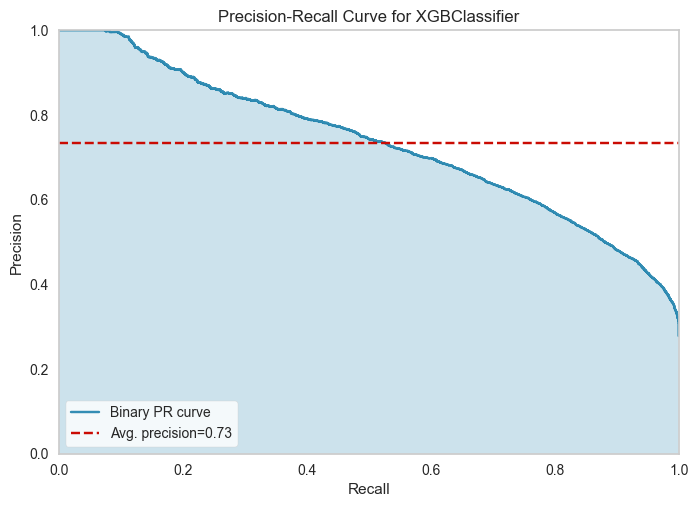

In [65]:
# Showing 'PR Curve' plot
plot_model(estimator=experiment4_model_tuned, plot='pr')

Notes:

`Precision-Recall (PR) Curve` is a curve that combines Precision and Recall in a single visualization.
* The higher on y-axis the curve (above represented by blue line) is, model would performs better.
    * Ideal classifier would have perfect Precision and Recall at all thresholds (symmetrical lines from `y=1` to `x=1`; hugging top-right side).
* `Average precision` summarizes this plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.
* PR Curve is useful to visualize how the choice of threshold affects classifier performance, and can even helps to select the best threshold for a specific problem.
    * Since the main objective in this project is to maximize `F0.5`, user can find **the best threshold for `XGBClassifier`** by calculation below.
    * Best threshold is defined as a certain point in the curve which maximizes the `F0.5` score: the best compromise between maximizing both Precision (twice as important) and Recall when there is a trade-off between them as shown in the curve.
    $$\text{F$_β$ Score}=(1+\beta^2) \times \frac{(\text{Precision} \times \text{Recall})}{(\beta^2 \times \text{Precision}) + \text{Recall}}$$

In [66]:
# Importing library for calculating the best threshold
from sklearn.metrics import precision_recall_curve

# Computing precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_true=y_train_transformed4, 
                                                       probas_pred=experiment4_model_tuned.predict_proba(X_train_transformed4)[:, 1])

# Defining 'beta' value used in this project
beta = 0.5

# Calculating 'Fβ' score for different probability thresholds
fbeta_score_ = ((1 + (beta**2)) * precision * recall) / (((beta**2) * precision) + recall)

# Finding maximum 'Fβ' score at specific threshold
best_fbeta_score = np.argmax(fbeta_score_)
print('Best Threshold: %f' % (thresholds[best_fbeta_score]))

Best Threshold: 0.662908


### ROC Curve & AUC Score

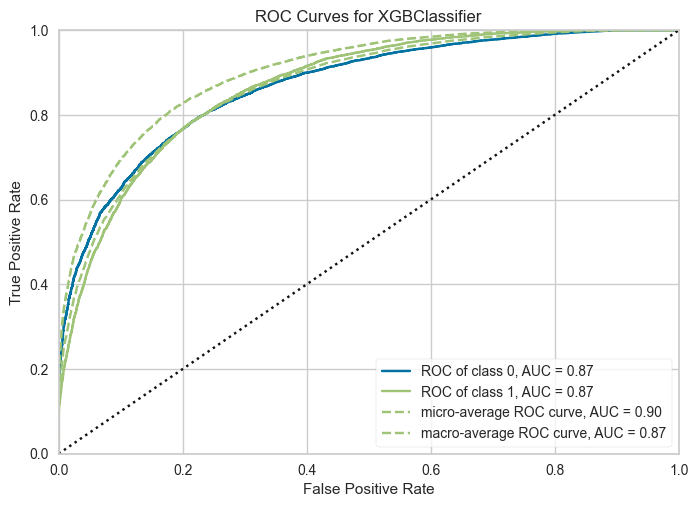

In [67]:
# Showing 'ROC-AUC' plot
plot_model(estimator=experiment4_model_tuned, plot='auc')

Notes:

`ROC Curve` or Receiver Operating Characteristic Curve in machine learning is a chart that visualizes the tradeoff between True Positive Rate (TPR) and False Positive Rate (FPR) for each classes.
$$TPR=\frac{TP}{TP + FN}$$
$$FPR=\frac{FP}{FP + TN}$$
* The higher TPR and the lower FPR for each threshold is the better, and so for classifiers that have curves that are more top-left side are better.
    * To give a single score for a classifier model across all threshold values, the Area Under Curve (`AUC`) can be calculated.
    * AUC scores for both classes (`0.87`) indicate that model performs well in identifying both TPR (booking that will be cancelled) and FPR (booking that will not).
* `micro-average` is calculated by considering each element of the label globally (all classes), while `macro-average` calculate AUC score for each label, and find their unweighted mean (label imbalance already accounted for in this model).
    * Good average scores (`0.90` and `0.87`) also show that **`XGBClassifier` performs well in classifying both cancellation and non-cancellation**.

### Classification Report

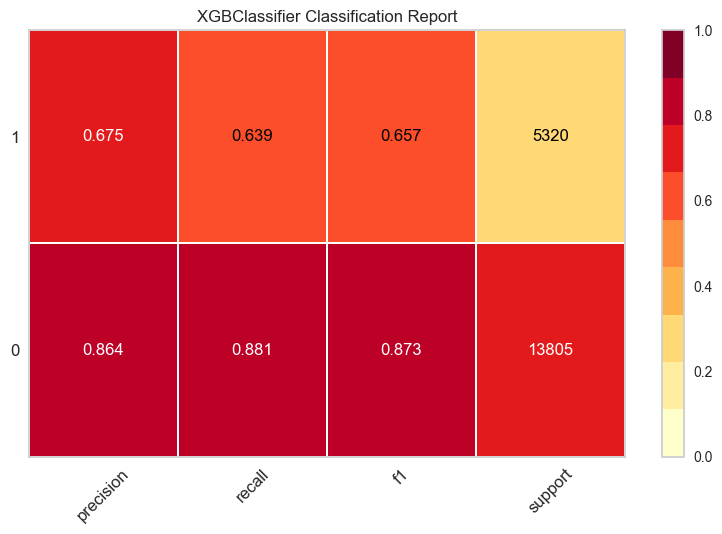

In [68]:
# Showing 'Class Report' plot
plot_model(estimator=experiment4_model_tuned, plot='class_report')

Notes:

* Class 0: 
    * Model has high scores, both in `Precision` and `Recall`
    * Identifies 86.3% instances as Class 0 and even identifies 87.5% of all actual Class 0.  
* Class 1: 
    * Model has low scores, both in `Precision` and `Recall`
    * Identifies only 68.3% instances as Class 1, and even more so, identifies only 63.4% of all actual Class 1.

This suggests that **`XGBClassifier` has a bias towards predicting Class 0 more often than Class 1**. But as shown previously, model scores better when `F0.5` per classes is used as the metric.

In [69]:
# Showing 'F0.5'scores per classes
pd.DataFrame(data=fhalf_score4,
             index=['Class 0', 'Class 1'])\
                .rename(columns={0: 'F0.5'})

,F0.5
Class 0,0.8586
Class 1,0.8713


### Learning Curve

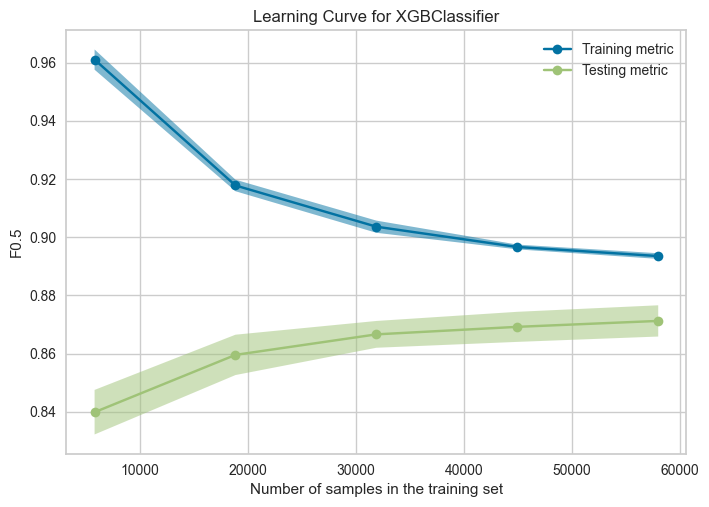

In [70]:
# Importing libraries for plotting 'Learning Curve'
from sklearn.metrics import make_scorer
from sklearn.model_selection import LearningCurveDisplay

# Making scorer from 'F0.5' metric
fbeta_scorer = make_scorer(score_func=fbeta_score, beta=0.5)

# Plotting 'Learning Curve'
LearningCurveDisplay.from_estimator(estimator=experiment4_model_tuned, X=X_train_transformed4, y=y_train_transformed4,
                                    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_),
                                    scoring=fbeta_scorer, score_name='F0.5', n_jobs=-1, random_state=random_state_,
                                    score_type='both', # Plotting curve for both train & test set
                                    shuffle=True, # Applying shuffle in train set
                                    line_kw={'marker': 'o'}) # Adding marker for each sample of train set

# Adding plot title
plt.title('Learning Curve for XGBClassifier')
plt.show()

Notes:

[`Learning Curve`](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) shows the training and validation (test) score of an estimator for varying numbers of training samples.
* `train_sizes` parameter set to `np.linspace(0.1, 10, 5)` by default
    * Equals to training samples sizes of 0.1, 2.575, 5.05, 7.525, and 10, but as a fraction of the maximum size of the training set.
* It is a tool to find out how much user can benefit from adding more training data, and whether the estimator suffers more from a variance error or bias error.

Plot above shows that both the training and validation curves & scores converge to a value that is relatively lower with increasing size of the training set. With this, user will probably **not benefit much from adding more training data**.
* It also shows that the model is —in actuality, based on the `F0.5` score per classes— very sensitive to changes in training data, and can result in significant changes in the estimate of the target when trained on different subsets of data from the same distribution (as shown by the changes in `F0.5` scores per training samples).
* This is the case of **overfitting**; when the model performs well on the training data but poorly on new, unseen test data.

### Reliability Curve

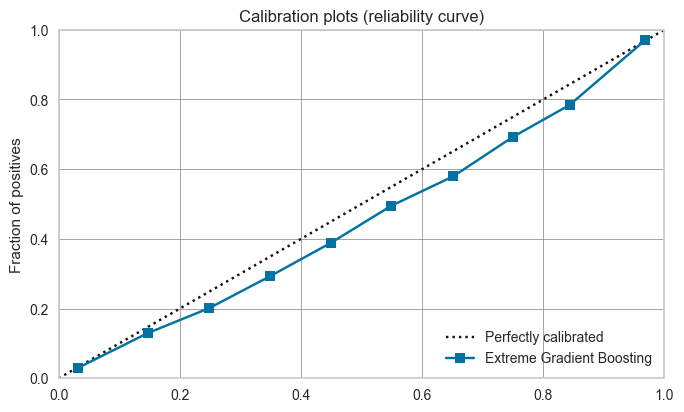

In [71]:
# Showing 'Reliability Curve' plot before calibration
plot_model(estimator=experiment4_model_tuned, plot='calibration')

Notes:

[`Calibration plot`](https://scikit-learn.org/stable/modules/calibration.html#calibration-curves) a.k.a. `reliability curve` plots the frequency of the positive label on the y-axis against the predicted probability of a model on the x-axis.
* Values for the y-axis is obtained by binning the predictions, such that the x-axis represents the average predicted probability in each bin.
* The y-axis is then the *fraction of positives* given the predictions of that bin, i.e. the proportion of samples whose class is the positive class (in each bin).
* Perfectly calibrated classifier will classify the samples, such that among the samples to which it gave a predicted probability value of, say, 0.8, 80% of those samples are indeed belong to the positive class.

Along the curve from `x = ~0.2 - 0.8`, the model **slightly overpredict** the probabilites of positive class samples.
* For example, among the samples to which the model gave a predicted probability of `0.2`, slightly less than 20% of those samples are in actuality belong to the positive class.
* Calibrating this model may be done through PyCaret's `calibrate_model()` function.
    * There are 2 ways to calibrate an estimator via the method parameter (1) `sigmoid` and (2) `isotonic`, which will be experimented below.

In [72]:
# Calibrating model with 'sigmoid' method
experiment4_model_sigmoid = experiment4.calibrate_model(estimator=experiment4_model_tuned, return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

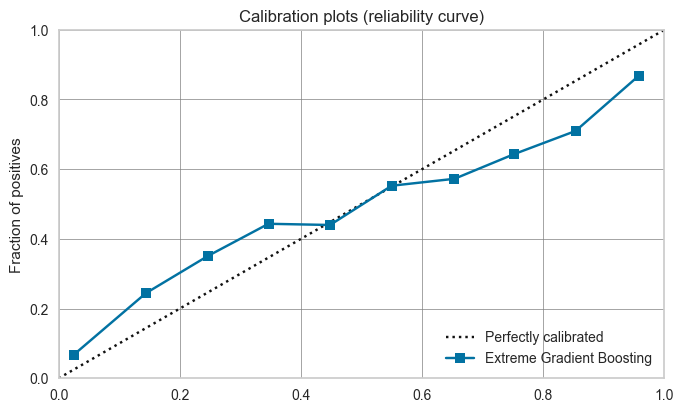

In [73]:
# Showing 'Reliability Curve' plot after calibration
plot_model(estimator=experiment4_model_sigmoid, plot='calibration')

In [74]:
# Calibrating model with 'isotonic' method
experiment4_model_isotonic = experiment4.calibrate_model(estimator=experiment4_model_tuned, method='isotonic', return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

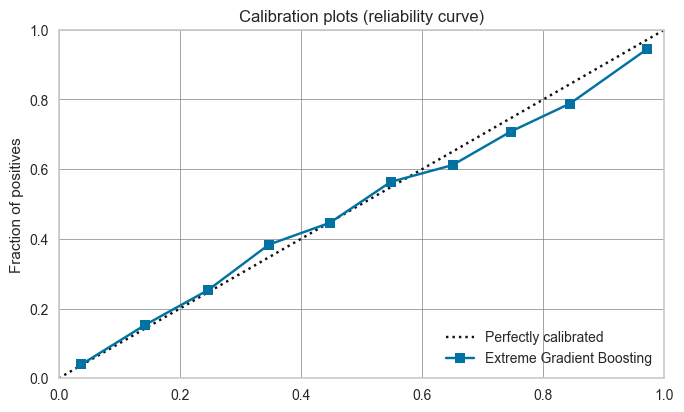

In [75]:
# Showing 'Reliability Curve' plot after calibration
plot_model(estimator=experiment4_model_isotonic, plot='calibration')

Notes:

* `Sigmoid` method is most effective for small sample size (< ~1000 samples), or when the uncalibrated model is under-confident, hence the reason why this method is inappropriate in this project and produce worse results than the next method.
* `Isotonic` method is more powerful but prone to overfitting, especially on small datasets. This method will perform as well as or better than `sigmoid` when there is enough data (> ~1000 samples) to avoid overfitting.
    * Some predicted probabilities are well-calibrated, but there are issues remains.
        * Slight underpredictions in `x = ~0.2 - 0.4` and `x = ~0.6`
        * Minimal overpredictions in `x = ~0.7 - 1`
    * Nevertheless, this method performs better and **will be implemented in further sections**.

### Model Finalization

In [76]:
# Applying function to finalize best model
final_model = experiment4.finalize_model(estimator=experiment4_model_isotonic)
final_model

Pipeline(memory=Memory(location=None),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['hotel',
                                                                                                    'arrival_day_type',
                                                                                                    'arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              drop_invariant=Fal...
                                                                     learning_rate=0.300000012,
                                                                     max_bin=256,
                                                                     max_cat_to_onehot=4,
                                                                     max_delta_step=0,
                                                                     max_depth=6,
                                                                     max_leaves=0,
                                                                     min_child_weight=1,
                                                                     missing=nan,
                                                                     monotone_constraints='()',
                                                                     n_estimators=100,
                                                                     n_jobs=-1,
                                                                     num_parallel_tree=1,
                                                                     objective='binary:logistic',
                                                                     predictor='auto',
                                                                     random_state=1,
                                                                     reg_alpha=0, ...),
                                        cv=5, ensemble=True, estimator=None,
                                        method='isotonic', n_jobs=None))],
         verbose=False)

Notes:

* Finalizing model consists of training a given estimator on entire dataset; including holdout/validation set.
    * Final model will then be ready to be used to make prediction on the test dataset.

## Model Explanation

### Model Mechanism

[`Extreme Gradient Boosting`](https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/notebooks/Machine-Learning-with-XGBoost-solution.ipynb) is a part of Gradient Boosting machine learning algorithms (including `Light Gradient Boosting Machine` and `CatBoost`).
* The term `Boosting` refers to iterative process to update a model by increasing the weights of data that are wrongly classified.
    * Boosting implements transformation of a certain 'weak learner' model into 'strong learner'
        * Weak learner is a model whose performance (in this case a classification algorithm) is at least slightly better than random chance.
    * Boosting uses several trees (Decision Tree algorithm) and grow them sequentially. This differs with Bagging and Random Forest models, in which the trees are independent from each other and does not require aggregated sample as in Bootstrap Aggregating.
* To see these implementations in this model, user may access the parameters applied.
    * Visualization of the trees also provided after.

In [77]:
# Accessing parameters applied in final model
final_model.get_params()

{'memory': Memory(location=None),
 'steps': [('ordinal',
   TransformerWrapper(exclude=None, include=None,
                      transformer=TransformerWrapper(exclude=None, include=None,
                                                     transformer=OrdinalEncoder(cols=['hotel',
                                                                                      'arrival_day_type',
                                                                                      'arrival_date_month',
                                                                                      'meal',
                                                                                      'country',
                                                                                      'distribution_channel',
                                                                                      'reserved_room_type',
                                                                                      'deposit

There are several things to note, based on parameters applied by the model (`actual_estimator__base_estimator__`):
1. `booster` parameter is `gbtree`. This means the weak learners —or boosters— are Decision Trees (DT) in this model
2. `objective` function —or loss function— is defined as `binary:logistic`. The objective function quantifies how far off a prediction is from the actual results.
    * User would want to minimize this; to have the smallest possible loss.
    * `binary:logistic` outputs the actual predicted probability of the positive class (in this case, that a booking is cancelled).
3. `n_estimators` is the number of gradient boosted trees implemented in model.
    * `actual_estimator__base_estimator__n_estimators` set to `100`.
    * It is equivalent to the number of boosting rounds/iterations.
    * Too many rounds may improve performance, at the cost of training time.

    <p align="center"> <img src='docs/Boosting_Rounds.png' width=50%> </p>
        
4. `max_depth` is the maximum tree depth allowed.
    * `actual_estimator__base_estimator__max_depth` set to `6`.
    * Tree depth is the length of the longest path from the root node to a leaf node.
    * Making this too high will give the model more variance (sensitivity to data fluctuations in the training set) and more potential to overfit.
    * Similar to `n_estimators`, increasing this parameter will also increase the training period.

    <p align="center"> <img src='docs/Max_Depth.png' width=25%> </p>

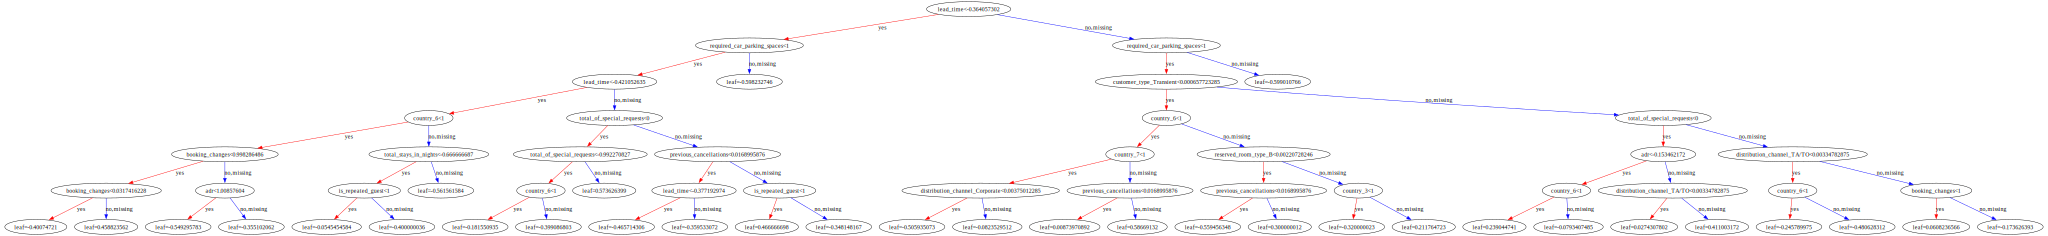

In [78]:
# Importing library for model mechanism explanation
import xgboost as xgb

# Showing model's tree plot 
xgb.to_graphviz(booster=experiment4_model_tuned) # Converting tree plot to GraphViz instance

Notes:

* `to_graphviz()` function required for `plot_tree()` provided by `XGBoostClassifier` in generating a decision tree for the model.
* `final_model` unable to be plotted with `plot_tree()` function, since `CalibratedClassifierCV` implementation in `final_model` does not support `get_dump` attribute required by `plot_tree()`.
    * Previous best model in `experiment4_model_tuned` will be used only for this explanation section.

There are multiple trees in the model, as defined by `n_estimators` parameter.
* `num_trees` parameter set to `0` by default, which only shows the first tree.
* DT separates the data into smaller subsets, for the objective of creating homogeneous class in each subset.
    * The whole, non-splitted dataset is called *Root*; as shown above, the topmost element in the tree (`lead_time`) is the root.
    * Subsets beginning from the first splits are called *Nodes*; i.e. subsets after the root starting from `required_car_parking_space` and so on.
        * Each node of the tree is a test on a feature (e.g. whether `lead_time` of an observation is `< -0.40` or not)
        * Splitting data is represented by *Branch*, or outcome of the test (either the `lead time < -0.40` or not) 
        * This also demonstrates the the maximum amount of length from the root node to the last leaf node (beginning from the first node) is `6`.
    * Subsets after the last splits are called *Leaves*.
        * The leaf output is a raw score, which will be converted to probability value at the end of model training.


Basic algorithm for DT consists of three steps:
1. Find the best splitter on each variable.
    * The best condition to split the data which results in homogeneous class.
    * For example, `lead_time < ~0.34` in the root node.
2. Select the best variable for splitting.
    * `XGBClassifier` uses [`Gain`](https://xgboost.readthedocs.io/en/stable/R-package/discoverYourData.html) in splitting the nodes.
        * The concept behind it is before splitting a feature to the branch, there were some wrongly classified data.
        * After adding the split in this feature, there are two new branch (`yes` or `no`), and each of these branches is more accurate than previous split.
        * I.e. one branch says if the observation is on this branch, then it should be classified as `1`, and the other branch says the exact opposite.
        * Hence, `Gain` is defined as improvement in accuracy brought by a feature to the branches it is on.
    * I.e. best variables in one of the first node is `required_car_parking_space`.
3. Perform splitting based on the result of Step 2.
    * Splitting is done until certain conditions are met:
        * Node contains only one class (target variable).
        * Number of observations in a node before/after splitting is less than pre-defined number (`min_child_weight` parameter).
        * Tree depth has reached its maximum.

`XGBClassifier` uses all of these trees and grow them sequentially.
* Plus implementing parallelization, so that the whole process becomes quicker.
* This model puts more weight towards Decision Tree which classifies wrong data (weak learner) and iterates them with the newly assigned weight until they become a strong learner.
* After all the iterative processes are finished, `final_model` combines all of the Trees that have been made into strong learner.

### Feature Importance

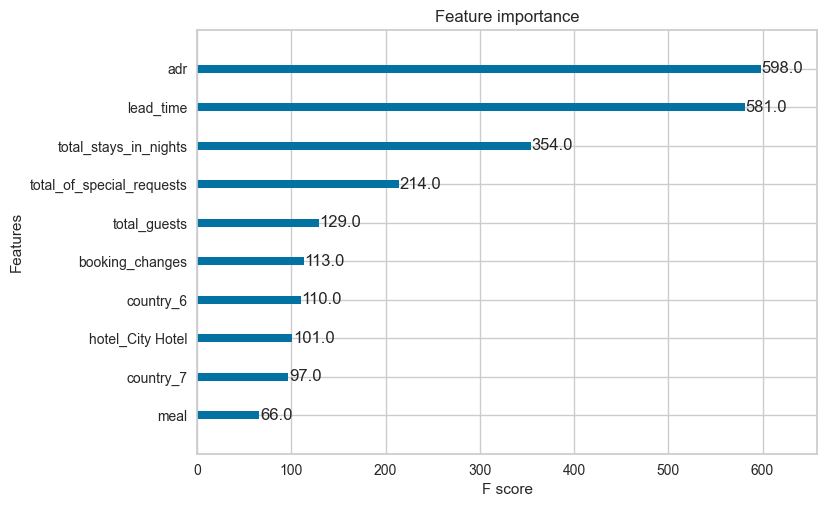

In [79]:
# Plotting 'Feature Importance' by 'Weight'
xgb.plot_importance(booster=experiment4_model_tuned, max_num_features=10)
plt.show()

Notes:

`Feature Importance` shows how predictive each feature is, for the target variable. Importance in `XGBClassifier` is calculated either by:
1. `weight` (shown above; `importance_type` set to `weight` by default) is defined as the number of times a feature appears in a tree, or
2. `gain` (shown below); the average `Gain` of splits which use the feature.

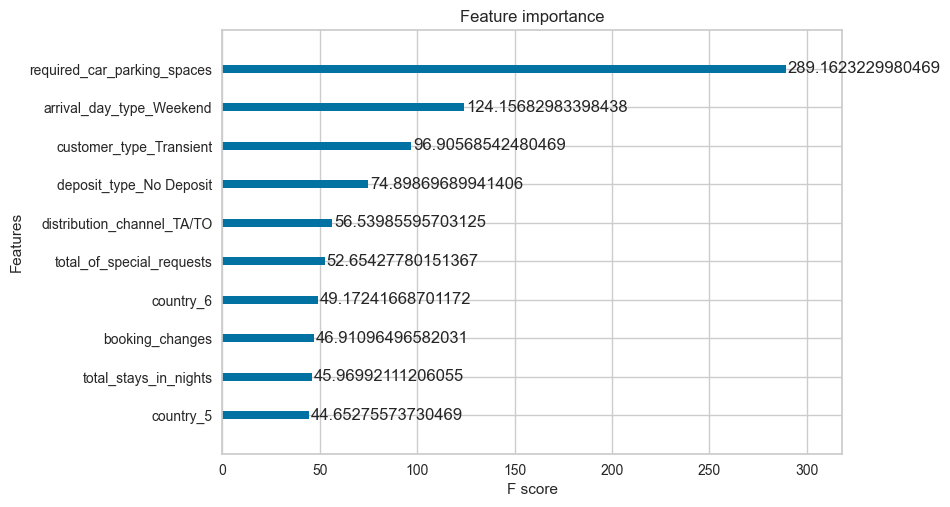

In [80]:
# Plotting 'Feature Importance' by 'Gain'
xgb.plot_importance(booster=experiment4_model_tuned, max_num_features=10, importance_type='gain')
plt.show()

Notes:

The ordering of features differs between `weight` and `gain`. This implies that:
1. Feature importance in `XGBClassifier` can be subjective (based on method implemented by the user), and
2. The number of appearances a feature has on a tree is not necessarily correlated to how much `Gain` it brings.
    * For example, `lead_time` and `adr` are continuous variables with lots of values in them. Hence, they appear more often than others in the tree.

In any case, `required_car_parking_spaces` has the highest amount of `Gain` than others. This suggests that **the number of parking space required by Hotel client is a strong predictor of booking cancellation**, since this feature contributes more than other in improving accuracy to classifications of `1` and `0`.

### Counterfactual Explanation

In [81]:
# Importing library for creating counterfactual explanation
import dice_ml

# Accessing original dataset & test set (before transformed/encoded)
dataset4, X_test4 = experiment4.get_config('dataset'), experiment4.get_config('X_test')

# Setting dataset for DiCE explanation instance
dice_data = dice_ml.Data(dataframe=dataset4, continuous_features=[var for var in numeric_vars], outcome_name='is_canceled')

# Setting model for DiCE explanation instance
dice_model = dice_ml.Model(model=final_model, backend='sklearn')

# Generating DiCE instance
dice_instance = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method='kdtree')

# Generating counterfactuals from DiCE instance 
dice_explainer = dice_instance.generate_counterfactuals(query_instances=X_test4[1:2], # Specifying input points for counterfactuals
                                                        total_CFs=5) # Specifying total number of counterfactuals displayed

with pd.option_context('display.max_columns', None):
    # Showing counterfactuals in dataframe format
    dice_explainer.visualize_as_dataframe(show_only_changes=True) # Highlighting only changes from the query instances

100%|██████████| 1/1 [00:22<00:00, 22.66s/it]

Query instance (original outcome : 0)


,hotel,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,Resort Hotel,3,Weekday,June,2,2,BB,ESP,TA/TO,0,0,A,0,No Deposit,0,Transient,143.0,1,1,0



Diverse Counterfactual set (new outcome: 1)


,hotel,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
85744,City Hotel,9,-,August,-,-,-,BLR,-,-,-,-,-,-,-,-,-,0,0,1
62740,City Hotel,8,Weekend,-,-,-,-,PRT,-,-,-,D,-,-,-,-,-,0,0,1
59058,City Hotel,8,-,March,-,-,-,DEU,-,-,-,-,-,-,-,-,-,0,0,1
59135,City Hotel,6,-,March,-,-,-,-,-,-,-,D,-,-,-,-,147.10000610351562,0,0,1
19499,-,5,-,May,-,4,-,PRT,-,-,-,G,-,-,-,-,-,0,0,1


Notes:

[Counterfactual explanations](https://github.com/interpretml/DiCE) by DiCE library provide "what-if" explanations for model output.
* Showing any perturbations (change of values in features) that change the output of a machine learning model.
* Given the train dataset (`dataset4`), user can construct a data object for DiCE.
    * Continuous and discrete features have different ways of perturbation; user need to specify the names in `continuous_features` parameter.
    * DiCE also requires the `outcome_name` variable (target) that the model will predict.
* `backend` parameter indicates the implementation type of DiCE. Since PyCaret models uses `sklearn` libraries, this value will be inputted.
* `query_instances` provides sample input which outcome is non-cancelled booking (class `0`).
    * Given the query input, user can generate counterfactual explanations (`5` as defined in `total_CFs`) to show perturbed inputs (`Diverse Counterfactual set` with `1` as the outcome) from the original input, where the model outputs class `0`.
* `show_only_changes` parameter highlights only the changes from the query instance.

Diverse Counterfactuals show that **changes in highlighted features would lead to a prediction of `1` (cancelled booking)**.
* Following previous explanation, slight change from `1` to `0` in `required_car_parking_spaces` leads to a predicted cancellation.
* Combinations of other variables also shown to demonstrate how a prediction changes in varying those features.

## Model Implementation

### Model Prediction

In [82]:
# Accessing train dataset
train4 = experiment4.get_config('train')

# Predicting model on train set
experiment4.predict_model(estimator=final_model, data=train4).sample(n=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost
0,Extreme Gradient Boosting,0.8397,0.9033,0.6283,0.7542,0.6855,0.5791,0.5835,0.7252,1569750.0000


,hotel,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,distribution_channel,is_repeated_guest,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,prediction_label,prediction_score
63523,City Hotel,47,Weekday,June,1,1,BB,ESP,TA/TO,0,...,0,No Deposit,0,Transient,101.699997,0,1,0,0,0.8177
5856,Resort Hotel,144,Weekday,August,7,3,HB,PRT,TA/TO,0,...,1,No Deposit,0,Transient,200.570007,0,0,1,1,0.7237
29931,Resort Hotel,0,Weekday,May,1,1,BB,PRT,Direct,0,...,0,No Deposit,0,Transient,60.000000,0,0,0,0,0.8844
86919,City Hotel,261,Weekday,August,5,2,BB,DEU,Direct,0,...,0,No Deposit,0,Transient,99.000000,0,0,0,0,0.7690
47043,City Hotel,50,Weekday,March,3,2,BB,ESP,TA/TO,0,...,0,No Deposit,0,Transient,106.199997,0,1,1,0,0.5770


In [83]:
# Accessing test dataset
test4 = experiment4.get_config('test')

# Predicting model on test set
experiment4.predict_model(estimator=final_model, data=test4).sample(n=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost
0,Extreme Gradient Boosting,0.8407,0.9038,0.6291,0.7572,0.6873,0.5816,0.5861,0.7276,667175.0000


,hotel,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,distribution_channel,is_repeated_guest,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,prediction_label,prediction_score
37666,City Hotel,40,Weekday,March,3,1,BB,COL,TA/TO,0,...,1,No Deposit,0,Transient,88.500000,0,0,1,0,0.7711
60473,City Hotel,23,Weekday,April,5,3,BB,FRA,TA/TO,0,...,0,No Deposit,0,Transient,110.839996,0,2,0,0,0.8851
72364,City Hotel,5,Weekday,November,1,2,BB,DEU,TA/TO,0,...,0,No Deposit,0,Transient,120.000000,0,3,0,0,0.9758
9570,Resort Hotel,77,Weekday,July,4,2,BB,CN,TA/TO,0,...,0,No Deposit,0,Transient,198.750000,0,0,1,1,0.8625
65487,City Hotel,98,Weekend,July,3,3,BB,NLD,TA/TO,0,...,0,No Deposit,0,Transient,137.699997,0,2,0,0,0.9211


Notes:

`XGBClassifier` achieves `F0.5` score of `0.7295` in training set, and `0.7308` in test set.
* Indicating a minuscule amount of increasing performance and generalization.
* Additionally, perfomances on unseen dataset are shown below.

In [84]:
# Predicting model on unseen dataset
df_predict = experiment4.predict_model(estimator=final_model, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F0.5,Cost
0,Extreme Gradient Boosting,0.8255,0.8797,0.5918,0.7298,0.6536,0.5387,0.5439,0.6973,810775.0000


### Prediction Analysis

In [85]:
# Binning probability scores
bin = pd.cut(x=df_predict.prediction_score, bins=5, 
             labels=[1, 2, 3, 4, 5]) # Specifying labels for bins

# Adding bins to prediction dataframe
df_predict['group'] = bin

# Verifying process
df_predict.sample(n=5)

,hotel,lead_time,arrival_day_type,arrival_date_month,total_stays_in_nights,total_guests,meal,country,market_segment,distribution_channel,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,prediction_label,prediction_score,group
74473,City Hotel,10,Weekday,January,2,1,SC,FRA,Online TA,TA/TO,...,No Deposit,0,Transient,88.000000,0,1,0,0,0.7800,3
7473,Resort Hotel,281,Weekday,January,7,2,BB,CN,Online TA,TA/TO,...,No Deposit,0,Transient,37.799999,0,0,1,1,0.7868,3
66032,City Hotel,43,Weekday,August,1,3,BB,HUN,Direct,Direct,...,No Deposit,0,Transient,131.149994,0,2,0,0,0.9746,5
59391,City Hotel,62,Weekday,March,4,3,BB,DEU,Online TA,TA/TO,...,No Deposit,0,Transient,101.150002,0,2,0,0,0.7941,3
47560,City Hotel,222,Weekend,April,3,3,BB,ITA,Online TA,TA/TO,...,No Deposit,0,Transient,145.800003,0,1,1,1,0.7607,3


Notes:
* `prediction_label` inputted by PyCaret through `predict_model()` function.
* `prediction_score` also provided to show the probability of each predictions.
    * Probability ranges from 50% to 100%, as shown below.

In [86]:
# Showing range of probability scores per bins
display(df_predict.groupby(by='group').agg(func={'prediction_score': ['min', 'max']}))

prediction_score        
                   min     max
group                         
1               0.5000  0.5999
2               0.6001  0.7000
3               0.7001  0.8000
4               0.8001  0.9000
5               0.9001  1.0000

In [87]:
# Importing libraries for classification scores
from sklearn.metrics import *

# Creating empty list for classification scores
scores = []

# Iterating unique values in bins
for value in df_predict.group.unique():

    # Grouping prediction dataframe
    df_value = df_predict[df_predict.group == value]

    # Computing classification scores per group
    accuracy = accuracy_score(y_true=df_value.is_canceled, y_pred=df_value.prediction_label)
    roc_auc = roc_auc_score(y_true=df_value.is_canceled, y_score=df_value.prediction_label, 
                            average='weighted', multi_class='ovr') # Uses PyCaret default parameter
    recall = recall_score(y_true=df_value.is_canceled, y_pred=df_value.prediction_label, average='weighted')
    precision = precision_score(y_true=df_value.is_canceled, y_pred=df_value.prediction_label, average='weighted')
    f1 = f1_score(y_true=df_value.is_canceled, y_pred=df_value.prediction_label, average='weighted')
    kappa = cohen_kappa_score(y1=df_value.is_canceled, y2=df_value.prediction_label)
    mcc = matthews_corrcoef(y_true=df_value.is_canceled, y_pred=df_value.prediction_label)
    fhalf_0 = fbeta_score(y_true=df_value.is_canceled, y_pred=df_value.prediction_label, beta=0.5, average=None)[0]
    fhalf_1 = fbeta_score(y_true=df_value.is_canceled, y_pred=df_value.prediction_label, beta=0.5, average=None)[1]
    cost = calculate_cost(y=df_value.is_canceled, y_pred=df_value.prediction_label)

    # Adding classification scores to empty list
    scores.append({'Group': value,
                   'Accuracy': accuracy,
                   'Auc': roc_auc,
                   'Recall': recall,
                   'F1': f1,
                   'Kappa': kappa,
                   'MCC': mcc,
                   'Precision': precision,
                   'F0.5 Class 0': fhalf_0,
                   'F0.5 Class 1': fhalf_1,
                   'Cost': cost})

# Converting score list to dataframe
df_scores = pd.DataFrame(data=scores).set_index(keys='Group')\
                                     .sort_values(by=['Precision', 'F0.5 Class 0', 
                                                      'F0.5 Class 1', 'Cost'], ascending=False) # Sorting scores by important metrics

# Showing classification score per bins
display(df_scores)

,Accuracy,Auc,Recall,F1,Kappa,MCC,Precision,F0.5 Class 0,F0.5 Class 1,Cost
Group,,,,,,,,,,
5,0.964961,0.876012,0.964961,0.963226,0.823978,0.830751,0.964575,0.971946,0.904968,62675.0
4,0.832965,0.756232,0.832965,0.824023,0.558148,0.571151,0.828908,0.861053,0.736636,141300.0
3,0.749053,0.730943,0.749053,0.744568,0.473053,0.478798,0.748623,0.768430,0.715031,174250.0
2,0.642267,0.632050,0.642267,0.636275,0.268249,0.273182,0.641591,0.664322,0.606960,201200.0
1,0.538212,0.537776,0.538212,0.537279,0.075612,0.075859,0.538097,0.547603,0.527316,231350.0


Notes:
* `Accuracy` to `MCC` implemented by using parameter applied by PyCaret.
    * Accessible via `get_metrics()` function.
* For the main metrics of `Precision`, `F0.5` per class, and `Cost`, model performs the best 'symmetrically'
    * Highest probabilites in range of 90% to 100% also have the highest score in main metrics, and vice versa
    * Especially in `F0.5 Class 1`, this score reduced significantly from group 5 (highest bin) to group 4 (second highest).

### Cost Simulation

#### Before Model Implementation

* *Assumption*: 60% incorrect predictions on unseen data (using `df_predict`), with 40% FN and 20% FP.
* Calculation uses `Cost` per prediction error as defined in previous section.

In [88]:
# Showing cost per prediction error
with pd.option_context('display.float_format', '${:,.2f}'.format):
   display(pd.DataFrame(data=[false_negative, false_positive],
                        index=['FN', 'FP'])\
                           .rename(columns={0: 'Cost'}))

,Cost
FN,$175.00
FP,$300.00


In [89]:
# ...
pd.DataFrame(data=df_predict.shape,
             index=['Row', 'Column']).rename(columns={0: 'df_test'})

,df_test
Row,21249
Column,24


In [90]:
# Calculating cost simulation before model implementation
cost_before = pd.DataFrame(data=[0.4 * df_predict.shape[0] * false_negative, 
                                 0.2 * df_predict.shape[0] * false_positive,
                                 (0.4 * df_predict.shape[0] * false_negative) + (0.2 * df_predict.shape[0] * false_positive)],
                            index=['FN', 'FP', 'Sum'])\
                              .rename(columns={0: 'Cost'})

# Showing result
with pd.option_context('display.float_format', '${:,.2f}'.format):
      display(cost_before)

,Cost
FN,"$1,487,430.00"
FP,"$1,274,940.00"
Sum,"$2,762,370.00"


#### After Model Implementation

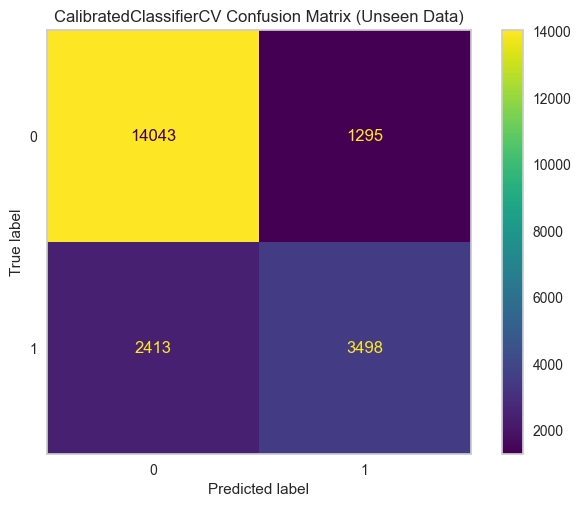

In [91]:
# Importing library for plotting 'Confusion Matrix'
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting 'Confusion Matrix'
ConfusionMatrixDisplay.from_predictions(y_true=df_predict.is_canceled, y_pred=df_predict.prediction_label)

# Removing grid in plot
plt.grid(None)

# Adding plot title
plt.title('CalibratedClassifierCV Confusion Matrix (Unseen Data)')
plt.show()

Notes:

Confusion Matrix is used to evaluate the accuracy of a classification, and can be implemented to calculate the cost-saving simulation by Hotel before and after implementing this model. And as shown above:
* False Negatives are predicted label of `0` (non-cancellation), when the true label is `1` (cancelled booking), which amount to `2485` observations in `df_predict` (equals to unseen data or `df_test`), while
* False Positives are predicted label of `1` (cancellation), when the true label is `0` (non-cancelled booking), which amount to `1275` observations.
* Difference between both implementations shows the amount of `Cost` that Hotel may saves after implementing the model.

In [92]:
# Calculating cost simulation after model implementation
cost_after = pd.DataFrame(data=[2485 * false_negative, 
                                1275 * false_positive,
                                (2485 * false_negative) + (1275 * false_positive)],
                           index=['FN', 'FP', 'Sum'])\
                              .rename(columns={0: 'Cost'})

# Calculating difference between implementations
cost_difference = cost_before.sub(other=cost_after).rename(columns={'Cost': 'Cost_Difference'})

# ...
cost_difference['Cost_Difference (%)'] = round(number=cost_difference['Cost_Difference'] / cost_before['Cost'] * 100, ndigits=0)
cost_before['Cost'] = cost_before['Cost'].apply('${:,.2f}'.format)
cost_after['Cost'] = cost_after['Cost'].apply('${:,.2f}'.format)
cost_difference['Cost_Difference'] = cost_difference['Cost_Difference'].apply('${:,.2f}'.format)

# Showing result
cost_before.join(other=cost_after, lsuffix='_Before', rsuffix='_After').join(other=cost_difference)

,Cost_Before,Cost_After,Cost_Difference,Cost_Difference (%)
FN,"$1,487,430.00","$434,875.00","$1,052,555.00",71.0
FP,"$1,274,940.00","$382,500.00","$892,440.00",70.0
Sum,"$2,762,370.00","$817,375.00","$1,944,995.00",70.0


### Limitation Analysis

#### Data Limitation

In [93]:
# Defining functions for explaining data limitation
def limitation_categorical(df): # Data limitation from categorical variables
    with pd.option_context('display.max_colwidth', 100):
        display(pd.DataFrame(data={'categorical_variables': df.columns,
                    'unique (n)': df.nunique(dropna=False).values,
                    'unique_sample': [df[var].unique() for var in df]}))

def limitation_numerical(df): # Data limitation from numerical variables
    with pd.option_context('display.max_colwidth', 75):
        display(pd.DataFrame(data={'numeric_variables': df.columns,
                    'unique (n)': df.nunique().values,
                    'unique_sample': [sorted(df[var].unique()) for var in df],
                    'min': [df[var].min() for var in df],
                    'max': [df[var].max() for var in df]}))

# Selecting variables per dataset
train_categorical, test_categorical = df_train.select_dtypes(include='object'), df_test.select_dtypes(include='object')
train_numerical, test_numerical = df_train.select_dtypes(include='number'), df_test.select_dtypes(include='number')

# Verifying process in categorical variables
limitation_categorical(train_categorical)
limitation_categorical(test_categorical)

,categorical_variables,unique (n),unique_sample
0,hotel,2,"[City Hotel, Resort Hotel]"
1,arrival_day_type,2,"[Weekend, Weekday]"
2,arrival_date_month,12,"[August, May, October, February, July, April, September, December, November, June, March, January]"
3,meal,4,"[BB, HB, SC, FB]"
4,country,172,"[BGR, FRA, ITA, PRT, CZE, GBR, USA, DEU, ESP, AUS, DNK, MKD, TUR, BEL, IRL, NOR, IRN, POL, AUT, ..."
5,market_segment,7,"[Online TA, Corporate, Offline TA/TO, Groups, Direct, Complementary, Aviation]"
6,distribution_channel,5,"[TA/TO, Corporate, Direct, GDS, Undefined]"
7,reserved_room_type,9,"[A, F, D, G, E, H, C, B, L]"
8,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
9,customer_type,4,"[Transient, Transient-Party, Contract, Group]"


,categorical_variables,unique (n),unique_sample
0,hotel,2,"[City Hotel, Resort Hotel]"
1,arrival_day_type,2,"[Weekend, Weekday]"
2,arrival_date_month,12,"[March, August, February, June, April, July, May, October, January, December, September, November]"
3,meal,4,"[BB, SC, HB, FB]"
4,country,136,"[IRL, CN, FRA, NLD, ESP, PRT, BEL, FIN, USA, GBR, CHL, CHN, BGR, DEU, SWE, AUT, ROU, NOR, ITA, C..."
5,market_segment,7,"[Online TA, Direct, Offline TA/TO, Corporate, Groups, Complementary, Aviation]"
6,distribution_channel,4,"[TA/TO, Direct, Corporate, GDS]"
7,reserved_room_type,9,"[D, A, F, B, E, G, C, H, L]"
8,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
9,customer_type,4,"[Transient, Transient-Party, Contract, Group]"


Notes:

`XGBClassifier` is trained on categorical and numerical variables (shown below) from `df_train`, and values in these features may not present in `df_test`:
* `country` has 172 labels in `df_train` but only 136 labels in `df_test`.
* `distribution_channel` has Undefined which is not present in `df_test`.
* `lead_time` ranges from 0-737 in `df_train`, but only up to 622 in `df_test`.
* `total_stays_in_nights` ranges from 0-56 in `df_train`, but only up to 42 in `df_test`.
* `previous_cancellations` ranges from 0-26 in `df_train`, but only up to 14 in `df_test`.
* `booking_changes` ranges from 0-18 in `df_train`, but only up to 622 in `df_test`.
* `days_in_waiting_list` contains values such as 19 and 20 which are not present in `df_test`.
* `adr` ranges from -6.38-5400 in `df_train`, but only from 0-510 in `df_test`.
* `required_car_parking_spaces` ranges from 0-8 in `df_train`, but only up to 3 in `df_test`.

This will cause a reduction in model performance evaluation. Also outside of values shown, predictions using those would be inaccurate.

In [94]:
# Verifying process in numerical variables
limitation_numerical(train_numerical)
limitation_numerical(test_numerical)

,numeric_variables,unique (n),unique_sample,min,max
0,is_canceled,2,"[0, 1]",0.00,1.0
1,lead_time,473,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...",0.00,737.0
2,total_stays_in_nights,40,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...",0.00,56.0
3,total_guests,11,"[1, 2, 3, 4, 5, 6, 10, 20, 26, 40, 55]",1.00,55.0
4,is_repeated_guest,2,"[0, 1]",0.00,1.0
5,previous_cancellations,14,"[0, 1, 2, 3, 4, 5, 6, 11, 13, 19, 21, 24, 25, 26]",0.00,26.0
6,booking_changes,19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]",0.00,18.0
7,days_in_waiting_list,117,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,...",0.00,391.0
8,adr,7659,"[-6.38, 0.0, 0.26, 0.5, 1.0, 1.56, 1.6, 1.8, 2.0, 2.4, 3.0, 4.0, 4.5, 5...",-6.38,5400.0
9,required_car_parking_spaces,5,"[0, 1, 2, 3, 8]",0.00,8.0


,numeric_variables,unique (n),unique_sample,min,max
0,is_canceled,2,"[0, 1]",0.0,1.0
1,lead_time,426,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...",0.0,622.0
2,total_stays_in_nights,32,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...",0.0,42.0
3,total_guests,11,"[1, 2, 3, 4, 5, 10, 12, 20, 26, 27, 50]",1.0,50.0
4,is_repeated_guest,2,"[0, 1]",0.0,1.0
5,previous_cancellations,10,"[0, 1, 2, 3, 4, 5, 6, 11, 13, 14]",0.0,14.0
6,booking_changes,15,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16]",0.0,16.0
7,days_in_waiting_list,91,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24,...",0.0,391.0
8,adr,4152,"[0.0, 1.0, 1.48, 1.56, 2.0, 3.0, 4.0, 4.5, 6.0, 6.5, 6.67, 6.9, 8.0, 9....",0.0,510.0
9,required_car_parking_spaces,4,"[0, 1, 2, 3]",0.0,3.0


#### Model Limitation

Since `XGBClassifier` works by implementing Decision Tree algorithm, weakness and limitation in this model may apply:

1. Slight changes in the input feature can have a big impact on the predicted outcome, which is usually not desirable.
2. Trees are also quite unstable. A few changes in the training set can create a completely different tree. This is because each split/branch depends on the parent split.
3. Decision trees are very interpretable –as long as they are short. The number of terminal nodes increases quickly with depth. The more terminal nodes and the deeper the tree, the more difficult it becomes to understand the decision rules of a tree.

---
# **Conclusion**

## Project Result

<p align="center"> <img src='docs/Flowchart_Result.png' width=50%> </p>

This section of the project aims to develop a machine learning classification model to predict Hotel booking cancellations, with focus in minimizing False Positive (Type I Error). A series of machine learning experimentations on Hotel's data have been carried out to find the best model in achieving that goal. 

This section consists of 4 main experiments, with each utilizing different implementations. The result for this project experimentations are as follows:
* Experiment #0 implements basic machine learning setup.
    * Transforming the strings of categorical variables into numerical by encoding is required, so that user can feed these variables into machine learning algorithms.
    * No additional treatment other than what is required in handling the data.
    * **Result**: Implemented as baseline model for the next experimentations.
* Experiment #1 manages the outlier issue by adding `RobustScaler` to previous pipeline.
    * Evaluation is done after this step to see if the problem is solved, by measuring the performance metrics of model in each experimentations.
    * The best model and pipeline in evaluation will be used as benchmark for further experimentation.
    * **Result**: Yields better (albeit slightly) performance than baseline model, and implemented in further experimentations.
* Experiment #2 handles cardinality issues by using `RareLabelEncoder`.
    * Evaluation and benchmarking process are also implemented after this step.
    * **Result**: Reduced performance in all metrics, and not carried through. 
* Experiment #3 treats imbalanced data by introducing NearMiss —a collection of undersampling methods—, while
* Experiment #4 treats imbalanced data by applying SMOTE (**S**ynthetic **M**inority **O**versampling **TE**chnique)
    * Best model (including its pipeline) will be selected after this stage.
    * **Result**: SMOTE produced the best result for `F0.5` per classes and added to model pipeline.
* Model calibration has also been performed, which results in utilizing *isotonic* method to increase the accuracy of probabilites for class predictions.

<style> table th:first-of-type {width: 10%} table th:nth-of-type(2) {width: 20%} </style>

| Pipeline | Variable Affected | Description |
| - | - | - |
| `OrdinalEncoder` | `meal` | Ordering labels in this category from the type of Hotel meal booked `SC < BB < HB < FB` |
| `BinaryEncoder` | `country` | Reducing high cardinality in this variable |
| | | Converting `177` categories to binary value of `10110001`, and encoding this value into `8` separate columns |
| `OneHotEncoder` | `hotel`, `arrival_day_type`, `arrival_date_month`, `distribution_channel`, `reserved_room_type`, `deposit_type`, `customer_type` | Converting relatively small cardinalities of selected categorical features to binary vectors of `1` and `0` |
| `RobustScaler` | Numerical features |

## Project Recommendation

### Hotel Stakeholder

* Make use of the model's predictions to proactively manage Hotel bookings. For example, if a certain booking is likely predicted to be cancelled, Stakeholder may want to implement strategies such as:
    * Offering attractive rate to resell the room to the same guest or others.
    * Tightening up cancellation policies during time periods where the most cancellations are predicted (e.g. requiring prepayment/deposit), and optimizing resource allocation during such period.
    * Creating custom sales campaign for guests with high risks of cancellation, and marketing push for any cancelled rooms.
    * Reaching out to guests to confirm their stays.
* Evaluate the impact of model results against Hotel's decision-making processes.
    * I.e. by using *A/B Testing* to better understand the rate of cancellation and changes in revenue before and after using the model.

### Project User

* Use original data without recategorization; namely `stays_in_weekend_nights`, `stays_in_week_nights`, `adults`, `children`, `babies`, and variables which provides `datetime` informations.
* `Phi-K` library may contains limitation in computing correlation, especially for categorical variables which needs to be investigated further.
* Utilize variable that is not included in this project's experimentation (`market_segment`) and exclude the other, similar variable (`distribution_channel`).
* Apply other solution for managing outlier, especially *Domain Knowledge Discretization*.
* Handle imbalanced data with various other strategies: e.g. `RandomUnder/OverSampler`, *Model Penalization*, and `ADASYN`.
* Generating new feature by *Feature Crossing* or *Polynomial Expansion* may make the model gain a better understanding of the underlying patterns in the data, and therefore improving model's performance.
* Implement model which is not included in this section (`CatBoost Classifier`).
* Putting more focus on business-side metric of Hotel `Cost` instead of conventional metrics like `Precision` and `F0.5` applied in this project.
* Increasing hyperparameter gridspace may also improve model's performance, and Hotel Stakeholder may also be more interested in focusing on the `Cost` metric instead of model's classification accuracy.

## Model Deployment

Model deployment refers to integration process of machine learning model with any available and/or implemented systems or architecture.
* In the context of Hotel business operation, `XGBoost Classifier` may be assimilated with Hotel's Property Management System (PMS), as mentioned in previous part of this project.
* Model would receives booking data as input to be processed by the integrated system, and outputting prediction result to help with user's (especially Hotel Stakeholder's) decision-making process.

There are two strategies in deployment phase of a model:
1. *Batch Prediction*
    * This prediction strategy typically runs model prediction at a particular time of a day, or multiple times a day at fixed interval.
    * It is useful when user are not waiting for real-time decisions, and able to batch input data any time.
    * As the batch prediction pipeline runs (usually maintained with scheduler to decide when the model should runs prediction for new data), new predicted data keeps appending to certain location in the system (mainly saved in database; either locally or in cloud database provider).
    * As for Hotel management system, **this strategy is suitable for when there is no demand for any instantaneous decision based on model's prediction**.
        * I.e. in non-peak season when Hotel room demand is comparatively low, which correlates with low booking cancellation rate.
        * Manual user-interface implementation in inputting batch data for prediction may also be done with this strategy.

2. *Streaming Prediction*
    * This strategy performs real-time inference to provide user with prediction result after interacting with the data.
    * Useful to avoid complex triggering in model deployment (i.e. large amounts of data and training time) and in scheduling model architecture as new data arrives.
    * A streaming deployment will consume higher resource than batch processing, because there is usually an Application Programming Interface (API) to create decision on-the-fly, based on a particular data's interaction/behaviour/attributes.
    * **This strategy is also suitable for Hotel in certain conditions**:
        1. *Event-driven applications*: model responds in real-time to specific events or triggers.
            * E.g. a significant change in certain variables not seen previously.
            * New value of `20` in `required_car_parking_spaces` which significantly differs from training and testing data of the model would necessitate a real-time prediction.
        2. *Real-time decision-making*: model processes data as it arrives in time-sensitive condition.
            * As described previously, high demand in peak season with high cancellation rate is suitable for applying this strategy.
        3. *Scalable processing*: model operates on large data volumes from multiple sources, ensuring efficiency in handling the data.
            * Consider a situation when Hotel is operating the business as a large branch with other smaller hotels in various locations. Predicting cancellation together with the other hotels would be more efficient by streaming strategy and using API, rather than using the batch method.

In [95]:
# # Saving final_model
# save_model(model=final_model, model_name='final_model')

# # Saving df_train & df_test
# df_train.to_csv(path_or_buf='df_train.csv', index=False)
# df_test.to_csv(path_or_buf='df_test.csv', index=False)

# # Outputting version info for libraries in this notebook
# import session_info
# session_info.show(write_req_file=True, req_file_name='Hotel_Booking_Demand_Part_2_requirements.txt')